* 데이터 개수에 따른 RMSE 측정 함수 생성

In [1]:
def data_sample_metrics(n, event):
    
    import pandas as pd
    import sqlite3
    import numpy as np
    import matplotlib.pyplot as plt
    import datetime
    import seaborn as sns
    from dateutil.relativedelta import relativedelta
    
    df = pd.read_csv("C:/Users/gram/OneDrive/바탕 화면/stock_project/data/{0}.csv".format(event))
    df.rename(columns={'Unnamed: 0':'date'}, inplace=True)
    df['date'] = df['date'].astype('str')
    
    end_date = pd.to_datetime(df['date'][0])
    start_date = pd.to_datetime(df['date'][len(df) - 1])
    diff = (end_date - start_date).days
    print(start_date)
    print(end_date)
    print(diff)
    
    if diff % 365 == 0:
        num_iter = (diff // 365) // n
    else:
        num_iter = (diff // 365) // n + 1
    
    print(num_iter)  
    
    RMSE_list = []
    
    for i in range(1, num_iter + 1 + 1):
        df = pd.read_csv("C:/Users/gram/OneDrive/바탕 화면/stock_project/data/{0}.csv".format(event))
        df.rename(columns={'Unnamed: 0':'date'}, inplace=True)
        df['date'] = df['date'].astype('str')
        df['date'] = pd.to_datetime(df['date'])
        df.set_index('date', inplace = True)
        if i == num_iter + 1:
            df = df[:]
        else:
            num_year = n * i
            year = end_date - relativedelta(years= num_year)
            year = year.strftime("%Y-%m-%d")
            df = df.loc[year:]

        from sklearn.preprocessing import MinMaxScaler
        # 피처값 스케일링
        scaler = MinMaxScaler()
        df[['open','high','low','volume']] = scaler.fit_transform(df[['open','high','low','volume']])
        # 타켓 스케일링
        scaler1 = MinMaxScaler()
        df['close'] = scaler1.fit_transform(df['close'].values.reshape(-1,1))
        
        from sklearn.model_selection import train_test_split
        x_train, x_test, y_train, y_test = train_test_split(df.drop('close', 1), df['close'], test_size=0.2, random_state=11, shuffle=False)
        
        import tensorflow as tf
        def windowed_dataset(series, window_size, batch_size, shuffle):
            series = tf.expand_dims(series, axis=-1)
            ds = tf.data.Dataset.from_tensor_slices(series)
            ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
            ds = ds.flat_map(lambda w: w.batch(window_size + 1))
            if shuffle:
                ds = ds.shuffle(1000)
            ds = ds.map(lambda w: (w[:-1], w[-1]))
            return ds.batch(batch_size).prefetch(1)
        
        WINDOW_SIZE=20
        BATCH_SIZE=32
        
        train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
        test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)
        
        from tensorflow.keras.models import Sequential
        from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
        from tensorflow.keras.losses import Huber
        from tensorflow.keras.optimizers import Adam
        from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


        model = Sequential([
            # 1차원 feature map 생성
            Conv1D(filters=32, kernel_size=5,
                   padding="causal",
                   activation="relu",
                   input_shape=[WINDOW_SIZE, 1]),
            # LSTM
            LSTM(16, activation='tanh'),
            Dense(16, activation="relu"),
            Dense(1),
            ])
        
        loss = Huber()
        optimizer = Adam(0.0005)
        model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])
        
        earlystopping = EarlyStopping(monitor='val_loss', patience=10)
        
        import os
        filename = os.path.join('tmp', 'ckeckpointer.ckpt')
        checkpoint = ModelCheckpoint(filename, 
                                     save_weights_only=True, 
                                     save_best_only=True, 
                                     monitor='val_loss', 
                                     verbose=1)

        history = model.fit(train_data, 
                            validation_data=(test_data), 
                            epochs=50, 
                            callbacks=[checkpoint, earlystopping])
        
        model.load_weights(filename)
        
        pred = model.predict(test_data)
        
        rescaled_y_test = scaler1.inverse_transform(np.array(y_test).reshape(-1, 1))
        rescaled_pred = scaler1.inverse_transform(np.array(pred).reshape(-1,1))

        rescaled_y_test 
        
        rescaled_pred = scaler1.inverse_transform(np.array(pred).reshape(-1,1))
        rescaled_pred
        
        MSE = np.square(np.subtract((rescaled_y_test)[20:], rescaled_pred)).mean()
        import math
        RMSE = math.sqrt(MSE)
        RMSE_list.append(RMSE)
        
    year_list = [n for n in range(len(RMSE_list))]
    
    print(RMSE_list)
    print(year_list)
    
    plt.plot(year_list, RMSE_list) # line 그래프를 그립니다
    plt.show() # 그래프를 화면에 보여줍니다

* 에너지

2007-07-25 00:00:00
2022-05-31 00:00:00
5424
3


C:\Users\gram\AppData\Local\Temp/ipykernel_8008/3864183076.py:43: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df = df.loc[year:]
C:\Users\gram\AppData\Local\Temp/ipykernel_8008/3864183076.py:54: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  x_train, x_test, y_train, y_test = train_test_split(df.drop('close', 1), df['close'], test_size=0.2, random_state=11, shuffle=False)


Epoch 1/50
     27/Unknown - 3s 13ms/step - loss: 0.1076 - mse: 0.2152
Epoch 1: val_loss improved from inf to 0.04075, saving model to tmp\ckeckpointer.ckpt
31/31 [==============================] - 4s 40ms/step - loss: 0.1031 - mse: 0.2062 - val_loss: 0.0408 - val_mse: 0.0815
Epoch 2/50
30/31 [============================>.] - ETA: 0s - loss: 0.0161 - mse: 0.0322
Epoch 2: val_loss improved from 0.04075 to 0.00252, saving model to tmp\ckeckpointer.ckpt
31/31 [==============================] - 1s 17ms/step - loss: 0.0161 - mse: 0.0321 - val_loss: 0.0025 - val_mse: 0.0050
Epoch 3/50
29/31 [===========================>..] - ETA: 0s - loss: 0.0028 - mse: 0.0056
Epoch 3: val_loss improved from 0.00252 to 0.00069, saving model to tmp\ckeckpointer.ckpt
31/31 [==============================] - 1s 18ms/step - loss: 0.0027 - mse: 0.0055 - val_loss: 6.8810e-04 - val_mse: 0.0014
Epoch 4/50
29/31 [===========================>..] - ETA: 0s - loss: 0.0020 - mse: 0.0041
Epoch 4: val_loss improved from 

Epoch 30/50
28/31 [==========================>...] - ETA: 0s - loss: 7.4010e-04 - mse: 0.0015
Epoch 30: val_loss did not improve from 0.00020
31/31 [==============================] - 1s 13ms/step - loss: 7.3398e-04 - mse: 0.0015 - val_loss: 2.5349e-04 - val_mse: 5.0698e-04
Epoch 31/50
31/31 [==============================] - ETA: 0s - loss: 7.3695e-04 - mse: 0.0015
Epoch 31: val_loss did not improve from 0.00020
31/31 [==============================] - 1s 14ms/step - loss: 7.3695e-04 - mse: 0.0015 - val_loss: 4.1330e-04 - val_mse: 8.2659e-04
Epoch 32/50
30/31 [============================>.] - ETA: 0s - loss: 7.7620e-04 - mse: 0.0016
Epoch 32: val_loss did not improve from 0.00020
31/31 [==============================] - 1s 15ms/step - loss: 7.7497e-04 - mse: 0.0015 - val_loss: 2.5247e-04 - val_mse: 5.0494e-04
Epoch 33/50
28/31 [==========================>...] - ETA: 0s - loss: 7.3139e-04 - mse: 0.0015 
Epoch 33: val_loss did not improve from 0.00020
31/31 [============================

C:\Users\gram\AppData\Local\Temp/ipykernel_8008/3864183076.py:43: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df = df.loc[year:]
C:\Users\gram\AppData\Local\Temp/ipykernel_8008/3864183076.py:54: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  x_train, x_test, y_train, y_test = train_test_split(df.drop('close', 1), df['close'], test_size=0.2, random_state=11, shuffle=False)


Epoch 1/50
     61/Unknown - 3s 12ms/step - loss: 0.0667 - mse: 0.1334
Epoch 1: val_loss improved from inf to 0.00178, saving model to tmp\ckeckpointer.ckpt
61/61 [==============================] - 5s 30ms/step - loss: 0.0667 - mse: 0.1334 - val_loss: 0.0018 - val_mse: 0.0036
Epoch 2/50
59/61 [============================>.] - ETA: 0s - loss: 0.0029 - mse: 0.0058
Epoch 2: val_loss improved from 0.00178 to 0.00035, saving model to tmp\ckeckpointer.ckpt
61/61 [==============================] - 1s 17ms/step - loss: 0.0028 - mse: 0.0057 - val_loss: 3.5092e-04 - val_mse: 7.0184e-04
Epoch 3/50
61/61 [==============================] - ETA: 0s - loss: 9.9186e-04 - mse: 0.0020
Epoch 3: val_loss improved from 0.00035 to 0.00017, saving model to tmp\ckeckpointer.ckpt
61/61 [==============================] - 1s 15ms/step - loss: 9.9186e-04 - mse: 0.0020 - val_loss: 1.7442e-04 - val_mse: 3.4883e-04
Epoch 4/50
58/61 [===========================>..] - ETA: 0s - loss: 5.9523e-04 - mse: 0.0012
Epoch 4:

Epoch 29/50
61/61 [==============================] - ETA: 0s - loss: 3.1932e-04 - mse: 6.3865e-04
Epoch 29: val_loss did not improve from 0.00011
61/61 [==============================] - 1s 20ms/step - loss: 3.1932e-04 - mse: 6.3865e-04 - val_loss: 1.2739e-04 - val_mse: 2.5478e-04
Epoch 30/50
60/61 [============================>.] - ETA: 0s - loss: 3.1103e-04 - mse: 6.2207e-04
Epoch 30: val_loss improved from 0.00011 to 0.00011, saving model to tmp\ckeckpointer.ckpt
61/61 [==============================] - 2s 26ms/step - loss: 3.0950e-04 - mse: 6.1899e-04 - val_loss: 1.1111e-04 - val_mse: 2.2223e-04
Epoch 31/50
59/61 [============================>.] - ETA: 0s - loss: 3.2719e-04 - mse: 6.5438e-04
Epoch 31: val_loss did not improve from 0.00011
61/61 [==============================] - 2s 24ms/step - loss: 3.2146e-04 - mse: 6.4291e-04 - val_loss: 1.2434e-04 - val_mse: 2.4867e-04
Epoch 32/50
60/61 [============================>.] - ETA: 0s - loss: 3.1321e-04 - mse: 6.2643e-04
Epoch 32: val

C:\Users\gram\AppData\Local\Temp/ipykernel_8008/3864183076.py:43: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df = df.loc[year:]
C:\Users\gram\AppData\Local\Temp/ipykernel_8008/3864183076.py:54: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  x_train, x_test, y_train, y_test = train_test_split(df.drop('close', 1), df['close'], test_size=0.2, random_state=11, shuffle=False)


Epoch 1/50
     88/Unknown - 4s 12ms/step - loss: 0.0251 - mse: 0.0502
Epoch 1: val_loss improved from inf to 0.00177, saving model to tmp\ckeckpointer.ckpt
92/92 [==============================] - 5s 22ms/step - loss: 0.0243 - mse: 0.0486 - val_loss: 0.0018 - val_mse: 0.0035
Epoch 2/50
90/92 [============================>.] - ETA: 0s - loss: 9.5385e-04 - mse: 0.0019
Epoch 2: val_loss improved from 0.00177 to 0.00075, saving model to tmp\ckeckpointer.ckpt
92/92 [==============================] - 2s 17ms/step - loss: 9.5354e-04 - mse: 0.0019 - val_loss: 7.5477e-04 - val_mse: 0.0015
Epoch 3/50
90/92 [============================>.] - ETA: 0s - loss: 6.7997e-04 - mse: 0.0014
Epoch 3: val_loss improved from 0.00075 to 0.00063, saving model to tmp\ckeckpointer.ckpt
92/92 [==============================] - 2s 18ms/step - loss: 6.8528e-04 - mse: 0.0014 - val_loss: 6.2628e-04 - val_mse: 0.0013
Epoch 4/50
91/92 [============================>.] - ETA: 0s - loss: 6.4054e-04 - mse: 0.0013
Epoch 4:

Epoch 28/50
91/92 [============================>.] - ETA: 0s - loss: 2.3427e-04 - mse: 4.6854e-04
Epoch 28: val_loss improved from 0.00024 to 0.00023, saving model to tmp\ckeckpointer.ckpt
92/92 [==============================] - 2s 24ms/step - loss: 2.3415e-04 - mse: 4.6829e-04 - val_loss: 2.3188e-04 - val_mse: 4.6376e-04
Epoch 29/50
90/92 [============================>.] - ETA: 0s - loss: 2.3509e-04 - mse: 4.7018e-04
Epoch 29: val_loss did not improve from 0.00023
92/92 [==============================] - 2s 23ms/step - loss: 2.3544e-04 - mse: 4.7087e-04 - val_loss: 2.9840e-04 - val_mse: 5.9681e-04
Epoch 30/50
92/92 [==============================] - ETA: 0s - loss: 2.3811e-04 - mse: 4.7622e-04
Epoch 30: val_loss did not improve from 0.00023
92/92 [==============================] - 3s 24ms/step - loss: 2.3811e-04 - mse: 4.7622e-04 - val_loss: 2.4385e-04 - val_mse: 4.8771e-04
Epoch 31/50
90/92 [============================>.] - ETA: 0s - loss: 2.3430e-04 - mse: 4.6860e-04
Epoch 31: val

C:\Users\gram\AppData\Local\Temp/ipykernel_8008/3864183076.py:54: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  x_train, x_test, y_train, y_test = train_test_split(df.drop('close', 1), df['close'], test_size=0.2, random_state=11, shuffle=False)


Epoch 1/50
     89/Unknown - 5s 13ms/step - loss: 0.0427 - mse: 0.0855
Epoch 1: val_loss improved from inf to 0.00307, saving model to tmp\ckeckpointer.ckpt
92/92 [==============================] - 6s 25ms/step - loss: 0.0418 - mse: 0.0835 - val_loss: 0.0031 - val_mse: 0.0061
Epoch 2/50
91/92 [============================>.] - ETA: 0s - loss: 0.0017 - mse: 0.0034
Epoch 2: val_loss improved from 0.00307 to 0.00068, saving model to tmp\ckeckpointer.ckpt
92/92 [==============================] - 2s 16ms/step - loss: 0.0017 - mse: 0.0034 - val_loss: 6.7795e-04 - val_mse: 0.0014
Epoch 3/50
91/92 [============================>.] - ETA: 0s - loss: 7.6982e-04 - mse: 0.0015
Epoch 3: val_loss improved from 0.00068 to 0.00063, saving model to tmp\ckeckpointer.ckpt
92/92 [==============================] - 2s 17ms/step - loss: 7.6888e-04 - mse: 0.0015 - val_loss: 6.2780e-04 - val_mse: 0.0013
Epoch 4/50
89/92 [============================>.] - ETA: 0s - loss: 6.9481e-04 - mse: 0.0014
Epoch 4: val_los

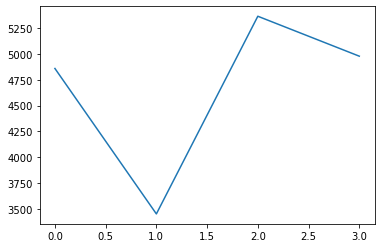

In [52]:
data_sample_metrics(5, '[에너지]SK이노베이션')

* 소재

1988-06-10 00:00:00
2022-05-31 00:00:00
12408
7


C:\Users\gram\AppData\Local\Temp/ipykernel_8008/3864183076.py:43: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df = df.loc[year:]
C:\Users\gram\AppData\Local\Temp/ipykernel_8008/3864183076.py:54: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  x_train, x_test, y_train, y_test = train_test_split(df.drop('close', 1), df['close'], test_size=0.2, random_state=11, shuffle=False)


Epoch 1/50
     31/Unknown - 3s 11ms/step - loss: 0.0421 - mse: 0.0842
Epoch 1: val_loss improved from inf to 0.00820, saving model to tmp\ckeckpointer.ckpt
31/31 [==============================] - 4s 52ms/step - loss: 0.0421 - mse: 0.0842 - val_loss: 0.0082 - val_mse: 0.0164
Epoch 2/50
26/31 [========================>.....] - ETA: 0s - loss: 0.0029 - mse: 0.0059
Epoch 2: val_loss improved from 0.00820 to 0.00347, saving model to tmp\ckeckpointer.ckpt
31/31 [==============================] - 1s 16ms/step - loss: 0.0028 - mse: 0.0056 - val_loss: 0.0035 - val_mse: 0.0069
Epoch 3/50
30/31 [============================>.] - ETA: 0s - loss: 0.0016 - mse: 0.0032
Epoch 3: val_loss improved from 0.00347 to 0.00129, saving model to tmp\ckeckpointer.ckpt
31/31 [==============================] - 1s 17ms/step - loss: 0.0016 - mse: 0.0032 - val_loss: 0.0013 - val_mse: 0.0026
Epoch 4/50
31/31 [==============================] - ETA: 0s - loss: 0.0010 - mse: 0.0021
Epoch 4: val_loss improved from 0.00

31/31 [==============================] - 1s 15ms/step - loss: 5.1661e-04 - mse: 0.0010 - val_loss: 5.9241e-04 - val_mse: 0.0012
Epoch 30/50
30/31 [============================>.] - ETA: 0s - loss: 4.9481e-04 - mse: 9.8962e-04
Epoch 30: val_loss improved from 0.00056 to 0.00053, saving model to tmp\ckeckpointer.ckpt
31/31 [==============================] - 1s 18ms/step - loss: 4.9482e-04 - mse: 9.8963e-04 - val_loss: 5.3423e-04 - val_mse: 0.0011
Epoch 31/50
29/31 [===========================>..] - ETA: 0s - loss: 4.9046e-04 - mse: 9.8092e-04
Epoch 31: val_loss improved from 0.00053 to 0.00053, saving model to tmp\ckeckpointer.ckpt
31/31 [==============================] - 1s 17ms/step - loss: 4.9716e-04 - mse: 9.9431e-04 - val_loss: 5.2800e-04 - val_mse: 0.0011
Epoch 32/50
31/31 [==============================] - ETA: 0s - loss: 4.6100e-04 - mse: 9.2200e-04
Epoch 32: val_loss improved from 0.00053 to 0.00050, saving model to tmp\ckeckpointer.ckpt
31/31 [==============================] - 

C:\Users\gram\AppData\Local\Temp/ipykernel_8008/3864183076.py:43: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df = df.loc[year:]
C:\Users\gram\AppData\Local\Temp/ipykernel_8008/3864183076.py:54: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  x_train, x_test, y_train, y_test = train_test_split(df.drop('close', 1), df['close'], test_size=0.2, random_state=11, shuffle=False)


Epoch 1/50
     59/Unknown - 4s 14ms/step - loss: 0.0540 - mse: 0.1080
Epoch 1: val_loss improved from inf to 0.00332, saving model to tmp\ckeckpointer.ckpt
61/61 [==============================] - 5s 27ms/step - loss: 0.0525 - mse: 0.1050 - val_loss: 0.0033 - val_mse: 0.0066
Epoch 2/50
61/61 [==============================] - ETA: 0s - loss: 0.0030 - mse: 0.0059
Epoch 2: val_loss improved from 0.00332 to 0.00148, saving model to tmp\ckeckpointer.ckpt
61/61 [==============================] - 1s 14ms/step - loss: 0.0030 - mse: 0.0059 - val_loss: 0.0015 - val_mse: 0.0030
Epoch 3/50
60/61 [============================>.] - ETA: 0s - loss: 0.0011 - mse: 0.0021
Epoch 3: val_loss improved from 0.00148 to 0.00063, saving model to tmp\ckeckpointer.ckpt
61/61 [==============================] - 1s 14ms/step - loss: 0.0011 - mse: 0.0021 - val_loss: 6.3049e-04 - val_mse: 0.0013
Epoch 4/50
59/61 [============================>.] - ETA: 0s - loss: 9.2243e-04 - mse: 0.0018
Epoch 4: val_loss improved f

C:\Users\gram\AppData\Local\Temp/ipykernel_8008/3864183076.py:43: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df = df.loc[year:]
C:\Users\gram\AppData\Local\Temp/ipykernel_8008/3864183076.py:54: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  x_train, x_test, y_train, y_test = train_test_split(df.drop('close', 1), df['close'], test_size=0.2, random_state=11, shuffle=False)


Epoch 1/50
     90/Unknown - 3s 11ms/step - loss: 0.0017 - mse: 0.0033
Epoch 1: val_loss improved from inf to 0.00098, saving model to tmp\ckeckpointer.ckpt
92/92 [==============================] - 4s 20ms/step - loss: 0.0016 - mse: 0.0033 - val_loss: 9.8468e-04 - val_mse: 0.0020
Epoch 2/50
92/92 [==============================] - ETA: 0s - loss: 1.6155e-04 - mse: 3.2311e-04
Epoch 2: val_loss improved from 0.00098 to 0.00093, saving model to tmp\ckeckpointer.ckpt
92/92 [==============================] - 2s 15ms/step - loss: 1.6155e-04 - mse: 3.2311e-04 - val_loss: 9.3174e-04 - val_mse: 0.0019
Epoch 3/50
92/92 [==============================] - ETA: 0s - loss: 1.4915e-04 - mse: 2.9831e-04
Epoch 3: val_loss improved from 0.00093 to 0.00089, saving model to tmp\ckeckpointer.ckpt
92/92 [==============================] - 1s 14ms/step - loss: 1.4915e-04 - mse: 2.9831e-04 - val_loss: 8.9036e-04 - val_mse: 0.0018
Epoch 4/50
90/92 [============================>.] - ETA: 0s - loss: 1.3610e-04 - 

Epoch 28/50
88/92 [===========================>..] - ETA: 0s - loss: 6.6842e-05 - mse: 1.3368e-04
Epoch 28: val_loss did not improve from 0.00034
92/92 [==============================] - 2s 15ms/step - loss: 6.7045e-05 - mse: 1.3409e-04 - val_loss: 3.5720e-04 - val_mse: 7.1439e-04
Epoch 29/50
89/92 [============================>.] - ETA: 0s - loss: 5.7017e-05 - mse: 1.1403e-04
Epoch 29: val_loss did not improve from 0.00034
92/92 [==============================] - 2s 16ms/step - loss: 5.8138e-05 - mse: 1.1628e-04 - val_loss: 3.5269e-04 - val_mse: 7.0538e-04
Epoch 30/50
92/92 [==============================] - ETA: 0s - loss: 6.0862e-05 - mse: 1.2172e-04
Epoch 30: val_loss did not improve from 0.00034
92/92 [==============================] - 2s 16ms/step - loss: 6.0862e-05 - mse: 1.2172e-04 - val_loss: 5.2062e-04 - val_mse: 0.0010
Epoch 31/50
89/92 [============================>.] - ETA: 0s - loss: 6.5799e-05 - mse: 1.3160e-04
Epoch 31: val_loss did not improve from 0.00034
92/92 [=====

C:\Users\gram\AppData\Local\Temp/ipykernel_8008/3864183076.py:43: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df = df.loc[year:]
C:\Users\gram\AppData\Local\Temp/ipykernel_8008/3864183076.py:54: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  x_train, x_test, y_train, y_test = train_test_split(df.drop('close', 1), df['close'], test_size=0.2, random_state=11, shuffle=False)


Epoch 1/50
    121/Unknown - 4s 12ms/step - loss: 0.0065 - mse: 0.0129
Epoch 1: val_loss improved from inf to 0.00167, saving model to tmp\ckeckpointer.ckpt
123/123 [==============================] - 5s 20ms/step - loss: 0.0064 - mse: 0.0127 - val_loss: 0.0017 - val_mse: 0.0033
Epoch 2/50
120/123 [============================>.] - ETA: 0s - loss: 3.0955e-04 - mse: 6.1910e-04
Epoch 2: val_loss improved from 0.00167 to 0.00027, saving model to tmp\ckeckpointer.ckpt
123/123 [==============================] - 2s 13ms/step - loss: 3.1688e-04 - mse: 6.3376e-04 - val_loss: 2.7357e-04 - val_mse: 5.4713e-04
Epoch 3/50
120/123 [============================>.] - ETA: 0s - loss: 2.6577e-04 - mse: 5.3155e-04
Epoch 3: val_loss improved from 0.00027 to 0.00020, saving model to tmp\ckeckpointer.ckpt
123/123 [==============================] - 2s 14ms/step - loss: 2.7328e-04 - mse: 5.4657e-04 - val_loss: 2.0174e-04 - val_mse: 4.0347e-04
Epoch 4/50
123/123 [==============================] - ETA: 0s - los

C:\Users\gram\AppData\Local\Temp/ipykernel_8008/3864183076.py:43: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df = df.loc[year:]
C:\Users\gram\AppData\Local\Temp/ipykernel_8008/3864183076.py:54: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  x_train, x_test, y_train, y_test = train_test_split(df.drop('close', 1), df['close'], test_size=0.2, random_state=11, shuffle=False)


Epoch 1/50
    154/Unknown - 4s 12ms/step - loss: 0.0034 - mse: 0.0068
Epoch 1: val_loss improved from inf to 0.00015, saving model to tmp\ckeckpointer.ckpt
156/156 [==============================] - 5s 18ms/step - loss: 0.0033 - mse: 0.0067 - val_loss: 1.5127e-04 - val_mse: 3.0253e-04
Epoch 2/50
154/156 [============================>.] - ETA: 0s - loss: 2.5483e-04 - mse: 5.0967e-04
Epoch 2: val_loss improved from 0.00015 to 0.00014, saving model to tmp\ckeckpointer.ckpt
156/156 [==============================] - 2s 14ms/step - loss: 2.5471e-04 - mse: 5.0942e-04 - val_loss: 1.4310e-04 - val_mse: 2.8621e-04
Epoch 3/50
153/156 [============================>.] - ETA: 0s - loss: 2.3703e-04 - mse: 4.7407e-04
Epoch 3: val_loss did not improve from 0.00014
156/156 [==============================] - 2s 14ms/step - loss: 2.3568e-04 - mse: 4.7136e-04 - val_loss: 1.4671e-04 - val_mse: 2.9341e-04
Epoch 4/50
155/156 [============================>.] - ETA: 0s - loss: 2.1806e-04 - mse: 4.3612e-04
Epo

C:\Users\gram\AppData\Local\Temp/ipykernel_8008/3864183076.py:43: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df = df.loc[year:]
C:\Users\gram\AppData\Local\Temp/ipykernel_8008/3864183076.py:54: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  x_train, x_test, y_train, y_test = train_test_split(df.drop('close', 1), df['close'], test_size=0.2, random_state=11, shuffle=False)


Epoch 1/50
    193/Unknown - 5s 12ms/step - loss: 0.0129 - mse: 0.0257
Epoch 1: val_loss improved from inf to 0.00025, saving model to tmp\ckeckpointer.ckpt
193/193 [==============================] - 6s 19ms/step - loss: 0.0129 - mse: 0.0257 - val_loss: 2.4740e-04 - val_mse: 4.9479e-04
Epoch 2/50
191/193 [============================>.] - ETA: 0s - loss: 1.8985e-04 - mse: 3.7969e-04
Epoch 2: val_loss improved from 0.00025 to 0.00011, saving model to tmp\ckeckpointer.ckpt
193/193 [==============================] - 3s 14ms/step - loss: 1.8879e-04 - mse: 3.7759e-04 - val_loss: 1.0632e-04 - val_mse: 2.1264e-04
Epoch 3/50
193/193 [==============================] - ETA: 0s - loss: 1.6555e-04 - mse: 3.3111e-04
Epoch 3: val_loss improved from 0.00011 to 0.00007, saving model to tmp\ckeckpointer.ckpt
193/193 [==============================] - 3s 15ms/step - loss: 1.6555e-04 - mse: 3.3111e-04 - val_loss: 7.0958e-05 - val_mse: 1.4192e-04
Epoch 4/50
192/193 [============================>.] - ETA: 

C:\Users\gram\AppData\Local\Temp/ipykernel_8008/3864183076.py:43: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df = df.loc[year:]
C:\Users\gram\AppData\Local\Temp/ipykernel_8008/3864183076.py:54: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  x_train, x_test, y_train, y_test = train_test_split(df.drop('close', 1), df['close'], test_size=0.2, random_state=11, shuffle=False)


Epoch 1/50
    219/Unknown - 11s 17ms/step - loss: 0.0017 - mse: 0.0034
Epoch 1: val_loss improved from inf to 0.00006, saving model to tmp\ckeckpointer.ckpt
222/222 [==============================] - 13s 26ms/step - loss: 0.0017 - mse: 0.0034 - val_loss: 5.8366e-05 - val_mse: 1.1673e-04
Epoch 2/50
221/222 [============================>.] - ETA: 0s - loss: 1.4902e-04 - mse: 2.9804e-04
Epoch 2: val_loss improved from 0.00006 to 0.00004, saving model to tmp\ckeckpointer.ckpt
222/222 [==============================] - 6s 27ms/step - loss: 1.4893e-04 - mse: 2.9786e-04 - val_loss: 3.6972e-05 - val_mse: 7.3944e-05
Epoch 3/50
221/222 [============================>.] - ETA: 0s - loss: 1.3680e-04 - mse: 2.7359e-04
Epoch 3: val_loss improved from 0.00004 to 0.00002, saving model to tmp\ckeckpointer.ckpt
222/222 [==============================] - 7s 29ms/step - loss: 1.3666e-04 - mse: 2.7332e-04 - val_loss: 2.2667e-05 - val_mse: 4.5335e-05
Epoch 4/50
222/222 [==============================] - ETA

C:\Users\gram\AppData\Local\Temp/ipykernel_8008/3864183076.py:54: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  x_train, x_test, y_train, y_test = train_test_split(df.drop('close', 1), df['close'], test_size=0.2, random_state=11, shuffle=False)


Epoch 1/50
    222/Unknown - 6s 15ms/step - loss: 0.0080 - mse: 0.0160
Epoch 1: val_loss improved from inf to 0.00013, saving model to tmp\ckeckpointer.ckpt
222/222 [==============================] - 9s 28ms/step - loss: 0.0080 - mse: 0.0160 - val_loss: 1.3378e-04 - val_mse: 2.6755e-04
Epoch 2/50
221/222 [============================>.] - ETA: 0s - loss: 1.6061e-04 - mse: 3.2123e-04
Epoch 2: val_loss improved from 0.00013 to 0.00009, saving model to tmp\ckeckpointer.ckpt
222/222 [==============================] - 6s 27ms/step - loss: 1.6046e-04 - mse: 3.2091e-04 - val_loss: 8.8314e-05 - val_mse: 1.7663e-04
Epoch 3/50
220/222 [============================>.] - ETA: 0s - loss: 1.5487e-04 - mse: 3.0974e-04
Epoch 3: val_loss did not improve from 0.00009
222/222 [==============================] - 4s 18ms/step - loss: 1.5451e-04 - mse: 3.0902e-04 - val_loss: 1.0026e-04 - val_mse: 2.0053e-04
Epoch 4/50
221/222 [============================>.] - ETA: 0s - loss: 1.5264e-04 - mse: 3.0527e-04
Epo

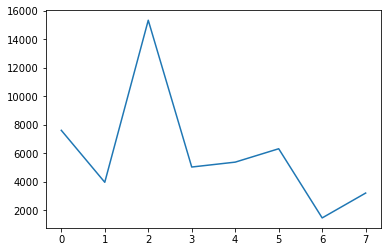

In [53]:
data_sample_metrics(5, '[소재]POSCO홀딩스')

* 산업재

2009-11-11 00:00:00
2022-05-31 00:00:00
4584
3


C:\Users\gram\AppData\Local\Temp/ipykernel_8008/3864183076.py:43: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df = df.loc[year:]
C:\Users\gram\AppData\Local\Temp/ipykernel_8008/3864183076.py:54: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  x_train, x_test, y_train, y_test = train_test_split(df.drop('close', 1), df['close'], test_size=0.2, random_state=11, shuffle=False)


Epoch 1/50
     28/Unknown - 4s 12ms/step - loss: 0.0178 - mse: 0.0356
Epoch 1: val_loss improved from inf to 0.00109, saving model to tmp\ckeckpointer.ckpt
31/31 [==============================] - 5s 40ms/step - loss: 0.0168 - mse: 0.0336 - val_loss: 0.0011 - val_mse: 0.0022
Epoch 2/50
26/31 [========================>.....] - ETA: 0s - loss: 0.0016 - mse: 0.0031
Epoch 2: val_loss improved from 0.00109 to 0.00101, saving model to tmp\ckeckpointer.ckpt
31/31 [==============================] - 1s 15ms/step - loss: 0.0016 - mse: 0.0032 - val_loss: 0.0010 - val_mse: 0.0020
Epoch 3/50
27/31 [=========================>....] - ETA: 0s - loss: 0.0013 - mse: 0.0027
Epoch 3: val_loss did not improve from 0.00101
31/31 [==============================] - 1s 13ms/step - loss: 0.0013 - mse: 0.0027 - val_loss: 0.0011 - val_mse: 0.0021
Epoch 4/50
28/31 [==========================>...] - ETA: 0s - loss: 0.0013 - mse: 0.0027
Epoch 4: val_loss improved from 0.00101 to 0.00086, saving model to tmp\ckeckpo

31/31 [==============================] - 1s 20ms/step - loss: 4.1693e-04 - mse: 8.3385e-04 - val_loss: 3.9579e-04 - val_mse: 7.9158e-04
Epoch 30/50
29/31 [===========================>..] - ETA: 0s - loss: 4.3313e-04 - mse: 8.6625e-04
Epoch 30: val_loss improved from 0.00025 to 0.00025, saving model to tmp\ckeckpointer.ckpt
31/31 [==============================] - 1s 20ms/step - loss: 4.2897e-04 - mse: 8.5795e-04 - val_loss: 2.4718e-04 - val_mse: 4.9435e-04
Epoch 31/50
29/31 [===========================>..] - ETA: 0s - loss: 4.0946e-04 - mse: 8.1893e-04
Epoch 31: val_loss improved from 0.00025 to 0.00025, saving model to tmp\ckeckpointer.ckpt
31/31 [==============================] - 1s 21ms/step - loss: 4.0459e-04 - mse: 8.0919e-04 - val_loss: 2.4511e-04 - val_mse: 4.9023e-04
Epoch 32/50
29/31 [===========================>..] - ETA: 0s - loss: 4.0746e-04 - mse: 8.1493e-04
Epoch 32: val_loss improved from 0.00025 to 0.00024, saving model to tmp\ckeckpointer.ckpt
31/31 [==================

C:\Users\gram\AppData\Local\Temp/ipykernel_8008/3864183076.py:43: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df = df.loc[year:]
C:\Users\gram\AppData\Local\Temp/ipykernel_8008/3864183076.py:54: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  x_train, x_test, y_train, y_test = train_test_split(df.drop('close', 1), df['close'], test_size=0.2, random_state=11, shuffle=False)


Epoch 1/50
     61/Unknown - 4s 11ms/step - loss: 0.1017 - mse: 0.2034
Epoch 1: val_loss improved from inf to 0.01398, saving model to tmp\ckeckpointer.ckpt
61/61 [==============================] - 5s 27ms/step - loss: 0.1017 - mse: 0.2034 - val_loss: 0.0140 - val_mse: 0.0280
Epoch 2/50
61/61 [==============================] - ETA: 0s - loss: 0.0032 - mse: 0.0065
Epoch 2: val_loss did not improve from 0.01398
61/61 [==============================] - 1s 14ms/step - loss: 0.0032 - mse: 0.0065 - val_loss: 0.0149 - val_mse: 0.0298
Epoch 3/50
59/61 [============================>.] - ETA: 0s - loss: 0.0023 - mse: 0.0046
Epoch 3: val_loss improved from 0.01398 to 0.00941, saving model to tmp\ckeckpointer.ckpt
61/61 [==============================] - 1s 16ms/step - loss: 0.0023 - mse: 0.0046 - val_loss: 0.0094 - val_mse: 0.0188
Epoch 4/50
59/61 [============================>.] - ETA: 0s - loss: 0.0018 - mse: 0.0037
Epoch 4: val_loss improved from 0.00941 to 0.00522, saving model to tmp\ckeckpo

C:\Users\gram\AppData\Local\Temp/ipykernel_8008/3864183076.py:43: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df = df.loc[year:]
C:\Users\gram\AppData\Local\Temp/ipykernel_8008/3864183076.py:54: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  x_train, x_test, y_train, y_test = train_test_split(df.drop('close', 1), df['close'], test_size=0.2, random_state=11, shuffle=False)


Epoch 1/50
     75/Unknown - 4s 15ms/step - loss: 0.0296 - mse: 0.0591
Epoch 1: val_loss improved from inf to 0.00407, saving model to tmp\ckeckpointer.ckpt
77/77 [==============================] - 5s 31ms/step - loss: 0.0289 - mse: 0.0578 - val_loss: 0.0041 - val_mse: 0.0081
Epoch 2/50
77/77 [==============================] - ETA: 0s - loss: 0.0012 - mse: 0.0025
Epoch 2: val_loss improved from 0.00407 to 0.00063, saving model to tmp\ckeckpointer.ckpt
77/77 [==============================] - 1s 15ms/step - loss: 0.0012 - mse: 0.0025 - val_loss: 6.2689e-04 - val_mse: 0.0013
Epoch 3/50
76/77 [============================>.] - ETA: 0s - loss: 6.3758e-04 - mse: 0.0013
Epoch 3: val_loss improved from 0.00063 to 0.00015, saving model to tmp\ckeckpointer.ckpt
77/77 [==============================] - 1s 16ms/step - loss: 6.3749e-04 - mse: 0.0013 - val_loss: 1.4880e-04 - val_mse: 2.9761e-04
Epoch 4/50
74/77 [===========================>..] - ETA: 0s - loss: 5.6522e-04 - mse: 0.0011
Epoch 4: val

C:\Users\gram\AppData\Local\Temp/ipykernel_8008/3864183076.py:54: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  x_train, x_test, y_train, y_test = train_test_split(df.drop('close', 1), df['close'], test_size=0.2, random_state=11, shuffle=False)


Epoch 1/50
     73/Unknown - 4s 13ms/step - loss: 0.0631 - mse: 0.1261
Epoch 1: val_loss improved from inf to 0.00808, saving model to tmp\ckeckpointer.ckpt
77/77 [==============================] - 5s 28ms/step - loss: 0.0601 - mse: 0.1203 - val_loss: 0.0081 - val_mse: 0.0162
Epoch 2/50
77/77 [==============================] - ETA: 0s - loss: 0.0025 - mse: 0.0051
Epoch 2: val_loss improved from 0.00808 to 0.00393, saving model to tmp\ckeckpointer.ckpt
77/77 [==============================] - 2s 18ms/step - loss: 0.0025 - mse: 0.0051 - val_loss: 0.0039 - val_mse: 0.0079
Epoch 3/50
76/77 [============================>.] - ETA: 0s - loss: 0.0015 - mse: 0.0029
Epoch 3: val_loss improved from 0.00393 to 0.00169, saving model to tmp\ckeckpointer.ckpt
77/77 [==============================] - 2s 19ms/step - loss: 0.0015 - mse: 0.0029 - val_loss: 0.0017 - val_mse: 0.0034
Epoch 4/50
74/77 [===========================>..] - ETA: 0s - loss: 9.4307e-04 - mse: 0.0019
Epoch 4: val_loss improved from 

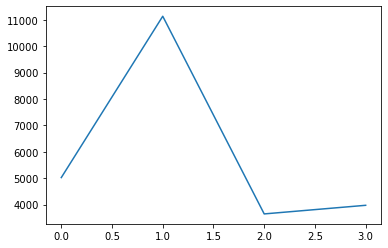

In [54]:
data_sample_metrics(5, '[산업재]SK')

* 경기관련소비재

1985-01-04 00:00:00
2022-05-31 00:00:00
13661
8


C:\Users\gram\AppData\Local\Temp/ipykernel_8008/3864183076.py:43: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df = df.loc[year:]
C:\Users\gram\AppData\Local\Temp/ipykernel_8008/3864183076.py:54: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  x_train, x_test, y_train, y_test = train_test_split(df.drop('close', 1), df['close'], test_size=0.2, random_state=11, shuffle=False)


Epoch 1/50
     29/Unknown - 6s 16ms/step - loss: 0.0984 - mse: 0.1967
Epoch 1: val_loss improved from inf to 0.01968, saving model to tmp\ckeckpointer.ckpt
31/31 [==============================] - 8s 63ms/step - loss: 0.0965 - mse: 0.1931 - val_loss: 0.0197 - val_mse: 0.0394
Epoch 2/50
28/31 [==========================>...] - ETA: 0s - loss: 0.0140 - mse: 0.0281
Epoch 2: val_loss improved from 0.01968 to 0.00261, saving model to tmp\ckeckpointer.ckpt
31/31 [==============================] - 1s 25ms/step - loss: 0.0134 - mse: 0.0267 - val_loss: 0.0026 - val_mse: 0.0052
Epoch 3/50
29/31 [===========================>..] - ETA: 0s - loss: 0.0044 - mse: 0.0088
Epoch 3: val_loss improved from 0.00261 to 0.00093, saving model to tmp\ckeckpointer.ckpt
31/31 [==============================] - 1s 26ms/step - loss: 0.0043 - mse: 0.0087 - val_loss: 9.3022e-04 - val_mse: 0.0019
Epoch 4/50
28/31 [==========================>...] - ETA: 0s - loss: 0.0021 - mse: 0.0042
Epoch 4: val_loss improved from 

Epoch 29/50
30/31 [============================>.] - ETA: 0s - loss: 4.0778e-04 - mse: 8.1556e-04
Epoch 29: val_loss did not improve from 0.00016
31/31 [==============================] - 1s 15ms/step - loss: 4.0850e-04 - mse: 8.1701e-04 - val_loss: 1.6957e-04 - val_mse: 3.3913e-04
Epoch 30/50
31/31 [==============================] - ETA: 0s - loss: 4.0185e-04 - mse: 8.0371e-04
Epoch 30: val_loss improved from 0.00016 to 0.00015, saving model to tmp\ckeckpointer.ckpt
31/31 [==============================] - 1s 17ms/step - loss: 4.0185e-04 - mse: 8.0371e-04 - val_loss: 1.5395e-04 - val_mse: 3.0790e-04
Epoch 31/50
28/31 [==========================>...] - ETA: 0s - loss: 3.8210e-04 - mse: 7.6421e-04
Epoch 31: val_loss did not improve from 0.00015
31/31 [==============================] - 1s 16ms/step - loss: 3.8096e-04 - mse: 7.6191e-04 - val_loss: 1.6499e-04 - val_mse: 3.2998e-04
Epoch 32/50
31/31 [==============================] - ETA: 0s - loss: 4.5705e-04 - mse: 9.1410e-04
Epoch 32: val

C:\Users\gram\AppData\Local\Temp/ipykernel_8008/3864183076.py:43: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df = df.loc[year:]
C:\Users\gram\AppData\Local\Temp/ipykernel_8008/3864183076.py:54: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  x_train, x_test, y_train, y_test = train_test_split(df.drop('close', 1), df['close'], test_size=0.2, random_state=11, shuffle=False)


Epoch 1/50
     59/Unknown - 5s 13ms/step - loss: 0.0184 - mse: 0.0368
Epoch 1: val_loss improved from inf to 0.01043, saving model to tmp\ckeckpointer.ckpt
61/61 [==============================] - 6s 30ms/step - loss: 0.0179 - mse: 0.0358 - val_loss: 0.0104 - val_mse: 0.0209
Epoch 2/50
59/61 [============================>.] - ETA: 0s - loss: 0.0020 - mse: 0.0040
Epoch 2: val_loss improved from 0.01043 to 0.00317, saving model to tmp\ckeckpointer.ckpt
61/61 [==============================] - 1s 17ms/step - loss: 0.0020 - mse: 0.0039 - val_loss: 0.0032 - val_mse: 0.0063
Epoch 3/50
61/61 [==============================] - ETA: 0s - loss: 9.4348e-04 - mse: 0.0019
Epoch 3: val_loss improved from 0.00317 to 0.00130, saving model to tmp\ckeckpointer.ckpt
61/61 [==============================] - 1s 18ms/step - loss: 9.4348e-04 - mse: 0.0019 - val_loss: 0.0013 - val_mse: 0.0026
Epoch 4/50
61/61 [==============================] - ETA: 0s - loss: 7.5424e-04 - mse: 0.0015
Epoch 4: val_loss improv

61/61 [==============================] - 1s 13ms/step - loss: 3.7436e-04 - mse: 7.4871e-04 - val_loss: 4.8202e-04 - val_mse: 9.6404e-04
Epoch 29/50
61/61 [==============================] - ETA: 0s - loss: 4.0372e-04 - mse: 8.0744e-04
Epoch 29: val_loss improved from 0.00048 to 0.00047, saving model to tmp\ckeckpointer.ckpt
61/61 [==============================] - 1s 13ms/step - loss: 4.0372e-04 - mse: 8.0744e-04 - val_loss: 4.7269e-04 - val_mse: 9.4537e-04
Epoch 30/50
59/61 [============================>.] - ETA: 0s - loss: 3.6004e-04 - mse: 7.2007e-04
Epoch 30: val_loss improved from 0.00047 to 0.00046, saving model to tmp\ckeckpointer.ckpt
61/61 [==============================] - 1s 13ms/step - loss: 3.5758e-04 - mse: 7.1517e-04 - val_loss: 4.6006e-04 - val_mse: 9.2012e-04
Epoch 31/50
61/61 [==============================] - ETA: 0s - loss: 3.4817e-04 - mse: 6.9634e-04
Epoch 31: val_loss improved from 0.00046 to 0.00045, saving model to tmp\ckeckpointer.ckpt
61/61 [==================

C:\Users\gram\AppData\Local\Temp/ipykernel_8008/3864183076.py:43: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df = df.loc[year:]
C:\Users\gram\AppData\Local\Temp/ipykernel_8008/3864183076.py:54: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  x_train, x_test, y_train, y_test = train_test_split(df.drop('close', 1), df['close'], test_size=0.2, random_state=11, shuffle=False)


Epoch 1/50
     89/Unknown - 5s 16ms/step - loss: 0.0219 - mse: 0.0438
Epoch 1: val_loss improved from inf to 0.00219, saving model to tmp\ckeckpointer.ckpt
92/92 [==============================] - 7s 29ms/step - loss: 0.0212 - mse: 0.0424 - val_loss: 0.0022 - val_mse: 0.0044
Epoch 2/50
92/92 [==============================] - ETA: 0s - loss: 7.7770e-04 - mse: 0.0016
Epoch 2: val_loss improved from 0.00219 to 0.00026, saving model to tmp\ckeckpointer.ckpt
92/92 [==============================] - 2s 21ms/step - loss: 7.7770e-04 - mse: 0.0016 - val_loss: 2.6339e-04 - val_mse: 5.2678e-04
Epoch 3/50
92/92 [==============================] - ETA: 0s - loss: 6.1249e-04 - mse: 0.0012
Epoch 3: val_loss improved from 0.00026 to 0.00024, saving model to tmp\ckeckpointer.ckpt
92/92 [==============================] - 2s 20ms/step - loss: 6.1249e-04 - mse: 0.0012 - val_loss: 2.3791e-04 - val_mse: 4.7581e-04
Epoch 4/50
90/92 [============================>.] - ETA: 0s - loss: 5.9600e-04 - mse: 0.0012


C:\Users\gram\AppData\Local\Temp/ipykernel_8008/3864183076.py:43: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df = df.loc[year:]
C:\Users\gram\AppData\Local\Temp/ipykernel_8008/3864183076.py:54: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  x_train, x_test, y_train, y_test = train_test_split(df.drop('close', 1), df['close'], test_size=0.2, random_state=11, shuffle=False)


Epoch 1/50
    120/Unknown - 6s 16ms/step - loss: 0.0153 - mse: 0.0305
Epoch 1: val_loss improved from inf to 0.00062, saving model to tmp\ckeckpointer.ckpt
123/123 [==============================] - 7s 25ms/step - loss: 0.0149 - mse: 0.0298 - val_loss: 6.2336e-04 - val_mse: 0.0012
Epoch 2/50
119/123 [============================>.] - ETA: 0s - loss: 4.4542e-04 - mse: 8.9084e-04
Epoch 2: val_loss improved from 0.00062 to 0.00010, saving model to tmp\ckeckpointer.ckpt
123/123 [==============================] - 2s 15ms/step - loss: 4.3936e-04 - mse: 8.7873e-04 - val_loss: 9.9779e-05 - val_mse: 1.9956e-04
Epoch 3/50
123/123 [==============================] - ETA: 0s - loss: 4.2225e-04 - mse: 8.4450e-04
Epoch 3: val_loss improved from 0.00010 to 0.00009, saving model to tmp\ckeckpointer.ckpt
123/123 [==============================] - 2s 14ms/step - loss: 4.2225e-04 - mse: 8.4450e-04 - val_loss: 9.1525e-05 - val_mse: 1.8305e-04
Epoch 4/50
121/123 [============================>.] - ETA: 0s -

C:\Users\gram\AppData\Local\Temp/ipykernel_8008/3864183076.py:43: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df = df.loc[year:]
C:\Users\gram\AppData\Local\Temp/ipykernel_8008/3864183076.py:54: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  x_train, x_test, y_train, y_test = train_test_split(df.drop('close', 1), df['close'], test_size=0.2, random_state=11, shuffle=False)


Epoch 1/50
    155/Unknown - 7s 20ms/step - loss: 0.0237 - mse: 0.0474
Epoch 1: val_loss improved from inf to 0.00109, saving model to tmp\ckeckpointer.ckpt
156/156 [==============================] - 8s 29ms/step - loss: 0.0236 - mse: 0.0473 - val_loss: 0.0011 - val_mse: 0.0022
Epoch 2/50
154/156 [============================>.] - ETA: 0s - loss: 2.8252e-04 - mse: 5.6505e-04
Epoch 2: val_loss improved from 0.00109 to 0.00029, saving model to tmp\ckeckpointer.ckpt
156/156 [==============================] - 3s 18ms/step - loss: 2.8119e-04 - mse: 5.6237e-04 - val_loss: 2.8562e-04 - val_mse: 5.7123e-04
Epoch 3/50
154/156 [============================>.] - ETA: 0s - loss: 2.3569e-04 - mse: 4.7137e-04
Epoch 3: val_loss improved from 0.00029 to 0.00022, saving model to tmp\ckeckpointer.ckpt
156/156 [==============================] - 3s 20ms/step - loss: 2.3391e-04 - mse: 4.6782e-04 - val_loss: 2.2206e-04 - val_mse: 4.4412e-04
Epoch 4/50
156/156 [==============================] - ETA: 0s - los

C:\Users\gram\AppData\Local\Temp/ipykernel_8008/3864183076.py:43: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df = df.loc[year:]
C:\Users\gram\AppData\Local\Temp/ipykernel_8008/3864183076.py:54: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  x_train, x_test, y_train, y_test = train_test_split(df.drop('close', 1), df['close'], test_size=0.2, random_state=11, shuffle=False)


Epoch 1/50
    192/Unknown - 5s 13ms/step - loss: 0.0487 - mse: 0.0975
Epoch 1: val_loss improved from inf to 0.00003, saving model to tmp\ckeckpointer.ckpt
193/193 [==============================] - 7s 20ms/step - loss: 0.0487 - mse: 0.0974 - val_loss: 3.2469e-05 - val_mse: 6.4938e-05
Epoch 2/50
190/193 [============================>.] - ETA: 0s - loss: 4.2988e-04 - mse: 8.5977e-04
Epoch 2: val_loss improved from 0.00003 to 0.00001, saving model to tmp\ckeckpointer.ckpt
193/193 [==============================] - 4s 19ms/step - loss: 4.2583e-04 - mse: 8.5165e-04 - val_loss: 8.2736e-06 - val_mse: 1.6547e-05
Epoch 3/50
192/193 [============================>.] - ETA: 0s - loss: 2.9599e-04 - mse: 5.9199e-04
Epoch 3: val_loss improved from 0.00001 to 0.00001, saving model to tmp\ckeckpointer.ckpt
193/193 [==============================] - 3s 14ms/step - loss: 2.9566e-04 - mse: 5.9132e-04 - val_loss: 7.1040e-06 - val_mse: 1.4208e-05
Epoch 4/50
191/193 [============================>.] - ETA: 

C:\Users\gram\AppData\Local\Temp/ipykernel_8008/3864183076.py:43: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df = df.loc[year:]
C:\Users\gram\AppData\Local\Temp/ipykernel_8008/3864183076.py:54: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  x_train, x_test, y_train, y_test = train_test_split(df.drop('close', 1), df['close'], test_size=0.2, random_state=11, shuffle=False)


Epoch 1/50
    229/Unknown - 8s 19ms/step - loss: 0.0108 - mse: 0.0217
Epoch 1: val_loss improved from inf to 0.00000, saving model to tmp\ckeckpointer.ckpt
229/229 [==============================] - 10s 28ms/step - loss: 0.0108 - mse: 0.0217 - val_loss: 1.9455e-06 - val_mse: 3.8910e-06
Epoch 2/50
229/229 [==============================] - ETA: 0s - loss: 1.9649e-04 - mse: 3.9297e-04
Epoch 2: val_loss did not improve from 0.00000
229/229 [==============================] - 6s 26ms/step - loss: 1.9649e-04 - mse: 3.9297e-04 - val_loss: 2.5029e-06 - val_mse: 5.0057e-06
Epoch 3/50
227/229 [============================>.] - ETA: 0s - loss: 1.8789e-04 - mse: 3.7577e-04
Epoch 3: val_loss did not improve from 0.00000
229/229 [==============================] - 9s 39ms/step - loss: 1.8666e-04 - mse: 3.7332e-04 - val_loss: 2.6357e-06 - val_mse: 5.2713e-06
Epoch 4/50
228/229 [============================>.] - ETA: 0s - loss: 1.7628e-04 - mse: 3.5256e-04
Epoch 4: val_loss improved from 0.00000 to 0.

229/229 [==============================] - ETA: 0s - loss: 6.5589e-05 - mse: 1.3118e-04
Epoch 28: val_loss did not improve from 0.00000
229/229 [==============================] - 9s 37ms/step - loss: 6.5589e-05 - mse: 1.3118e-04 - val_loss: 1.0126e-06 - val_mse: 2.0252e-06
Epoch 29/50
228/229 [============================>.] - ETA: 0s - loss: 6.6832e-05 - mse: 1.3366e-04
Epoch 29: val_loss did not improve from 0.00000
229/229 [==============================] - 13s 56ms/step - loss: 6.6650e-05 - mse: 1.3330e-04 - val_loss: 8.9389e-07 - val_mse: 1.7878e-06
Epoch 30/50
228/229 [============================>.] - ETA: 0s - loss: 6.5321e-05 - mse: 1.3064e-04
Epoch 30: val_loss improved from 0.00000 to 0.00000, saving model to tmp\ckeckpointer.ckpt
229/229 [==============================] - 7s 30ms/step - loss: 6.5150e-05 - mse: 1.3030e-04 - val_loss: 7.6644e-07 - val_mse: 1.5329e-06
Epoch 31/50
229/229 [==============================] - ETA: 0s - loss: 7.1563e-05 - mse: 1.4313e-04
Epoch 31: 

C:\Users\gram\AppData\Local\Temp/ipykernel_8008/3864183076.py:43: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df = df.loc[year:]
C:\Users\gram\AppData\Local\Temp/ipykernel_8008/3864183076.py:54: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  x_train, x_test, y_train, y_test = train_test_split(df.drop('close', 1), df['close'], test_size=0.2, random_state=11, shuffle=False)


Epoch 1/50
    247/Unknown - 7s 16ms/step - loss: 0.0085 - mse: 0.0170
Epoch 1: val_loss improved from inf to 0.00001, saving model to tmp\ckeckpointer.ckpt
247/247 [==============================] - 9s 23ms/step - loss: 0.0085 - mse: 0.0170 - val_loss: 1.0979e-05 - val_mse: 2.1959e-05
Epoch 2/50
245/247 [============================>.] - ETA: 0s - loss: 2.5320e-04 - mse: 5.0640e-04
Epoch 2: val_loss improved from 0.00001 to 0.00001, saving model to tmp\ckeckpointer.ckpt
247/247 [==============================] - 6s 22ms/step - loss: 2.5199e-04 - mse: 5.0398e-04 - val_loss: 6.6896e-06 - val_mse: 1.3379e-05
Epoch 3/50
247/247 [==============================] - ETA: 0s - loss: 2.4053e-04 - mse: 4.8106e-04
Epoch 3: val_loss improved from 0.00001 to 0.00001, saving model to tmp\ckeckpointer.ckpt
247/247 [==============================] - 6s 22ms/step - loss: 2.4053e-04 - mse: 4.8106e-04 - val_loss: 6.2827e-06 - val_mse: 1.2565e-05
Epoch 4/50
245/247 [============================>.] - ETA: 

C:\Users\gram\AppData\Local\Temp/ipykernel_8008/3864183076.py:54: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  x_train, x_test, y_train, y_test = train_test_split(df.drop('close', 1), df['close'], test_size=0.2, random_state=11, shuffle=False)


Epoch 1/50
    247/Unknown - 6s 13ms/step - loss: 0.0255 - mse: 0.0510
Epoch 1: val_loss improved from inf to 0.00001, saving model to tmp\ckeckpointer.ckpt
247/247 [==============================] - 7s 19ms/step - loss: 0.0255 - mse: 0.0510 - val_loss: 5.7608e-06 - val_mse: 1.1522e-05
Epoch 2/50
243/247 [============================>.] - ETA: 0s - loss: 4.8300e-04 - mse: 9.6600e-04
Epoch 2: val_loss did not improve from 0.00001
247/247 [==============================] - 5s 20ms/step - loss: 4.7652e-04 - mse: 9.5304e-04 - val_loss: 6.7102e-06 - val_mse: 1.3420e-05
Epoch 3/50
246/247 [============================>.] - ETA: 0s - loss: 2.0634e-04 - mse: 4.1268e-04
Epoch 3: val_loss did not improve from 0.00001
247/247 [==============================] - 4s 16ms/step - loss: 2.0604e-04 - mse: 4.1209e-04 - val_loss: 9.2302e-06 - val_mse: 1.8460e-05
Epoch 4/50
244/247 [============================>.] - ETA: 0s - loss: 1.7989e-04 - mse: 3.5978e-04
Epoch 4: val_loss improved from 0.00001 to 0.0

Epoch 29/50
243/247 [============================>.] - ETA: 0s - loss: 7.9684e-05 - mse: 1.5937e-04
Epoch 29: val_loss did not improve from 0.00000
247/247 [==============================] - 4s 17ms/step - loss: 7.8649e-05 - mse: 1.5730e-04 - val_loss: 2.4272e-06 - val_mse: 4.8545e-06
Epoch 30/50
245/247 [============================>.] - ETA: 0s - loss: 7.8318e-05 - mse: 1.5664e-04
Epoch 30: val_loss did not improve from 0.00000
247/247 [==============================] - 4s 15ms/step - loss: 7.7895e-05 - mse: 1.5579e-04 - val_loss: 2.2796e-06 - val_mse: 4.5593e-06
Epoch 31/50
246/247 [============================>.] - ETA: 0s - loss: 7.6742e-05 - mse: 1.5348e-04
Epoch 31: val_loss did not improve from 0.00000
247/247 [==============================] - 4s 17ms/step - loss: 7.6633e-05 - mse: 1.5327e-04 - val_loss: 2.5047e-06 - val_mse: 5.0095e-06
Epoch 32/50
246/247 [============================>.] - ETA: 0s - loss: 7.4172e-05 - mse: 1.4834e-04
Epoch 32: val_loss improved from 0.00000 t

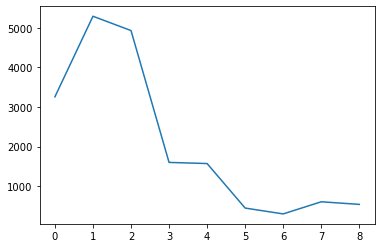

In [55]:
data_sample_metrics(5, '[경기관련소비재]현대차')

* 필수소비재

2007-09-28 00:00:00
2022-05-31 00:00:00
5359
3


C:\Users\gram\AppData\Local\Temp/ipykernel_8008/3864183076.py:43: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df = df.loc[year:]
C:\Users\gram\AppData\Local\Temp/ipykernel_8008/3864183076.py:54: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  x_train, x_test, y_train, y_test = train_test_split(df.drop('close', 1), df['close'], test_size=0.2, random_state=11, shuffle=False)


Epoch 1/50
     29/Unknown - 9s 32ms/step - loss: 0.1315 - mse: 0.2631
Epoch 1: val_loss improved from inf to 0.06364, saving model to tmp\ckeckpointer.ckpt
31/31 [==============================] - 11s 113ms/step - loss: 0.1300 - mse: 0.2600 - val_loss: 0.0636 - val_mse: 0.1273
Epoch 2/50
29/31 [===========================>..] - ETA: 0s - loss: 0.0212 - mse: 0.0423
Epoch 2: val_loss improved from 0.06364 to 0.00314, saving model to tmp\ckeckpointer.ckpt
31/31 [==============================] - 2s 41ms/step - loss: 0.0206 - mse: 0.0411 - val_loss: 0.0031 - val_mse: 0.0063
Epoch 3/50
31/31 [==============================] - ETA: 0s - loss: 0.0037 - mse: 0.0073
Epoch 3: val_loss improved from 0.00314 to 0.00073, saving model to tmp\ckeckpointer.ckpt
31/31 [==============================] - 2s 39ms/step - loss: 0.0037 - mse: 0.0073 - val_loss: 7.2711e-04 - val_mse: 0.0015
Epoch 4/50
30/31 [============================>.] - ETA: 0s - loss: 0.0025 - mse: 0.0050
Epoch 4: val_loss improved fro

31/31 [==============================] - 1s 24ms/step - loss: 7.4083e-04 - mse: 0.0015 - val_loss: 4.7315e-04 - val_mse: 9.4629e-04
Epoch 30/50
28/31 [==========================>...] - ETA: 0s - loss: 6.9994e-04 - mse: 0.0014
Epoch 30: val_loss did not improve from 0.00047
31/31 [==============================] - 1s 22ms/step - loss: 7.1502e-04 - mse: 0.0014 - val_loss: 5.2865e-04 - val_mse: 0.0011
Epoch 31/50
31/31 [==============================] - ETA: 0s - loss: 6.8969e-04 - mse: 0.0014
Epoch 31: val_loss improved from 0.00047 to 0.00044, saving model to tmp\ckeckpointer.ckpt
31/31 [==============================] - 1s 24ms/step - loss: 6.8969e-04 - mse: 0.0014 - val_loss: 4.3997e-04 - val_mse: 8.7993e-04
Epoch 32/50
29/31 [===========================>..] - ETA: 0s - loss: 6.7999e-04 - mse: 0.0014
Epoch 32: val_loss improved from 0.00044 to 0.00041, saving model to tmp\ckeckpointer.ckpt
31/31 [==============================] - 1s 22ms/step - loss: 6.9762e-04 - mse: 0.0014 - val_los

C:\Users\gram\AppData\Local\Temp/ipykernel_8008/3864183076.py:43: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df = df.loc[year:]
C:\Users\gram\AppData\Local\Temp/ipykernel_8008/3864183076.py:54: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  x_train, x_test, y_train, y_test = train_test_split(df.drop('close', 1), df['close'], test_size=0.2, random_state=11, shuffle=False)


Epoch 1/50
     58/Unknown - 3s 11ms/step - loss: 0.0418 - mse: 0.0836
Epoch 1: val_loss improved from inf to 0.00202, saving model to tmp\ckeckpointer.ckpt
61/61 [==============================] - 4s 24ms/step - loss: 0.0399 - mse: 0.0798 - val_loss: 0.0020 - val_mse: 0.0040
Epoch 2/50
61/61 [==============================] - ETA: 0s - loss: 0.0018 - mse: 0.0037
Epoch 2: val_loss improved from 0.00202 to 0.00171, saving model to tmp\ckeckpointer.ckpt
61/61 [==============================] - 1s 14ms/step - loss: 0.0018 - mse: 0.0037 - val_loss: 0.0017 - val_mse: 0.0034
Epoch 3/50
57/61 [===========================>..] - ETA: 0s - loss: 0.0013 - mse: 0.0026
Epoch 3: val_loss improved from 0.00171 to 0.00090, saving model to tmp\ckeckpointer.ckpt
61/61 [==============================] - 1s 14ms/step - loss: 0.0013 - mse: 0.0026 - val_loss: 8.9655e-04 - val_mse: 0.0018
Epoch 4/50
61/61 [==============================] - ETA: 0s - loss: 9.6346e-04 - mse: 0.0019
Epoch 4: val_loss improved f

61/61 [==============================] - 1s 14ms/step - loss: 3.2263e-04 - mse: 6.4526e-04 - val_loss: 2.2409e-04 - val_mse: 4.4819e-04
Epoch 28/50
60/61 [============================>.] - ETA: 0s - loss: 3.3684e-04 - mse: 6.7368e-04
Epoch 28: val_loss did not improve from 0.00021
61/61 [==============================] - 1s 14ms/step - loss: 3.3694e-04 - mse: 6.7388e-04 - val_loss: 2.2203e-04 - val_mse: 4.4406e-04
Epoch 29/50
61/61 [==============================] - ETA: 0s - loss: 3.2626e-04 - mse: 6.5252e-04
Epoch 29: val_loss did not improve from 0.00021
61/61 [==============================] - 1s 14ms/step - loss: 3.2626e-04 - mse: 6.5252e-04 - val_loss: 2.2338e-04 - val_mse: 4.4677e-04
Epoch 30/50
60/61 [============================>.] - ETA: 0s - loss: 3.2312e-04 - mse: 6.4624e-04
Epoch 30: val_loss improved from 0.00021 to 0.00021, saving model to tmp\ckeckpointer.ckpt
61/61 [==============================] - 1s 15ms/step - loss: 3.2434e-04 - mse: 6.4869e-04 - val_loss: 2.0709e-

C:\Users\gram\AppData\Local\Temp/ipykernel_8008/3864183076.py:43: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df = df.loc[year:]
C:\Users\gram\AppData\Local\Temp/ipykernel_8008/3864183076.py:54: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  x_train, x_test, y_train, y_test = train_test_split(df.drop('close', 1), df['close'], test_size=0.2, random_state=11, shuffle=False)


Epoch 1/50
     89/Unknown - 5s 17ms/step - loss: 0.0481 - mse: 0.0963
Epoch 1: val_loss improved from inf to 0.00223, saving model to tmp\ckeckpointer.ckpt
91/91 [==============================] - 6s 34ms/step - loss: 0.0476 - mse: 0.0952 - val_loss: 0.0022 - val_mse: 0.0045
Epoch 2/50
90/91 [============================>.] - ETA: 0s - loss: 0.0011 - mse: 0.0022
Epoch 2: val_loss improved from 0.00223 to 0.00151, saving model to tmp\ckeckpointer.ckpt
91/91 [==============================] - 3s 26ms/step - loss: 0.0011 - mse: 0.0022 - val_loss: 0.0015 - val_mse: 0.0030
Epoch 3/50
91/91 [==============================] - ETA: 0s - loss: 7.1880e-04 - mse: 0.0014
Epoch 3: val_loss improved from 0.00151 to 0.00066, saving model to tmp\ckeckpointer.ckpt
91/91 [==============================] - 2s 24ms/step - loss: 7.1880e-04 - mse: 0.0014 - val_loss: 6.6006e-04 - val_mse: 0.0013
Epoch 4/50
90/91 [============================>.] - ETA: 0s - loss: 5.9999e-04 - mse: 0.0012
Epoch 4: val_loss im

Epoch 28/50
89/91 [============================>.] - ETA: 0s - loss: 3.0640e-04 - mse: 6.1280e-04
Epoch 28: val_loss did not improve from 0.00031
91/91 [==============================] - 2s 22ms/step - loss: 3.0490e-04 - mse: 6.0980e-04 - val_loss: 3.3821e-04 - val_mse: 6.7641e-04
Epoch 29/50
88/91 [============================>.] - ETA: 0s - loss: 2.9397e-04 - mse: 5.8794e-04
Epoch 29: val_loss improved from 0.00031 to 0.00028, saving model to tmp\ckeckpointer.ckpt
91/91 [==============================] - 2s 20ms/step - loss: 2.9240e-04 - mse: 5.8481e-04 - val_loss: 2.7865e-04 - val_mse: 5.5730e-04
Epoch 30/50
89/91 [============================>.] - ETA: 0s - loss: 2.7102e-04 - mse: 5.4204e-04
Epoch 30: val_loss improved from 0.00028 to 0.00026, saving model to tmp\ckeckpointer.ckpt
91/91 [==============================] - 2s 21ms/step - loss: 2.7092e-04 - mse: 5.4185e-04 - val_loss: 2.6225e-04 - val_mse: 5.2450e-04
Epoch 31/50
89/91 [============================>.] - ETA: 0s - loss:

C:\Users\gram\AppData\Local\Temp/ipykernel_8008/3864183076.py:54: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  x_train, x_test, y_train, y_test = train_test_split(df.drop('close', 1), df['close'], test_size=0.2, random_state=11, shuffle=False)


Epoch 1/50
     91/Unknown - 3s 11ms/step - loss: 0.0436 - mse: 0.0873
Epoch 1: val_loss improved from inf to 0.00342, saving model to tmp\ckeckpointer.ckpt
91/91 [==============================] - 4s 20ms/step - loss: 0.0436 - mse: 0.0873 - val_loss: 0.0034 - val_mse: 0.0068
Epoch 2/50
90/91 [============================>.] - ETA: 0s - loss: 7.8409e-04 - mse: 0.0016
Epoch 2: val_loss improved from 0.00342 to 0.00220, saving model to tmp\ckeckpointer.ckpt
91/91 [==============================] - 2s 21ms/step - loss: 7.8419e-04 - mse: 0.0016 - val_loss: 0.0022 - val_mse: 0.0044
Epoch 3/50
88/91 [============================>.] - ETA: 0s - loss: 6.1778e-04 - mse: 0.0012
Epoch 3: val_loss improved from 0.00220 to 0.00144, saving model to tmp\ckeckpointer.ckpt
91/91 [==============================] - 2s 15ms/step - loss: 6.2024e-04 - mse: 0.0012 - val_loss: 0.0014 - val_mse: 0.0029
Epoch 4/50
91/91 [==============================] - ETA: 0s - loss: 5.1697e-04 - mse: 0.0010
Epoch 4: val_los

Epoch 28/50
91/91 [==============================] - ETA: 0s - loss: 3.0403e-04 - mse: 6.0806e-04
Epoch 28: val_loss did not improve from 0.00033
91/91 [==============================] - 2s 22ms/step - loss: 3.0403e-04 - mse: 6.0806e-04 - val_loss: 3.5516e-04 - val_mse: 7.1031e-04
Epoch 29/50
88/91 [============================>.] - ETA: 0s - loss: 3.2475e-04 - mse: 6.4950e-04
Epoch 29: val_loss improved from 0.00033 to 0.00030, saving model to tmp\ckeckpointer.ckpt
91/91 [==============================] - 2s 15ms/step - loss: 3.2449e-04 - mse: 6.4899e-04 - val_loss: 3.0025e-04 - val_mse: 6.0051e-04
Epoch 30/50
87/91 [===========================>..] - ETA: 0s - loss: 3.1231e-04 - mse: 6.2462e-04
Epoch 30: val_loss improved from 0.00030 to 0.00028, saving model to tmp\ckeckpointer.ckpt
91/91 [==============================] - 1s 13ms/step - loss: 3.1125e-04 - mse: 6.2250e-04 - val_loss: 2.8013e-04 - val_mse: 5.6026e-04
Epoch 31/50
91/91 [==============================] - ETA: 0s - loss:

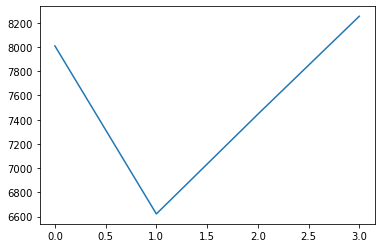

In [56]:
data_sample_metrics(5, '[필수소비재]CJ제일제당')

* 건강관리

2016-11-10 00:00:00
2022-05-31 00:00:00
2028
2


C:\Users\gram\AppData\Local\Temp/ipykernel_8008/3864183076.py:43: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df = df.loc[year:]
C:\Users\gram\AppData\Local\Temp/ipykernel_8008/3864183076.py:54: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  x_train, x_test, y_train, y_test = train_test_split(df.drop('close', 1), df['close'], test_size=0.2, random_state=11, shuffle=False)


Epoch 1/50
     28/Unknown - 3s 10ms/step - loss: 0.1319 - mse: 0.2639
Epoch 1: val_loss improved from inf to 0.00562, saving model to tmp\ckeckpointer.ckpt
31/31 [==============================] - 4s 37ms/step - loss: 0.1291 - mse: 0.2582 - val_loss: 0.0056 - val_mse: 0.0112
Epoch 2/50
31/31 [==============================] - ETA: 0s - loss: 0.0300 - mse: 0.0600
Epoch 2: val_loss did not improve from 0.00562
31/31 [==============================] - 1s 14ms/step - loss: 0.0300 - mse: 0.0600 - val_loss: 0.0185 - val_mse: 0.0371
Epoch 3/50
31/31 [==============================] - ETA: 0s - loss: 0.0058 - mse: 0.0115
Epoch 3: val_loss improved from 0.00562 to 0.00515, saving model to tmp\ckeckpointer.ckpt
31/31 [==============================] - 1s 17ms/step - loss: 0.0058 - mse: 0.0115 - val_loss: 0.0051 - val_mse: 0.0103
Epoch 4/50
31/31 [==============================] - ETA: 0s - loss: 0.0016 - mse: 0.0031
Epoch 4: val_loss improved from 0.00515 to 0.00087, saving model to tmp\ckeckpo

Epoch 28/50
31/31 [==============================] - ETA: 0s - loss: 6.3458e-04 - mse: 0.0013
Epoch 28: val_loss improved from 0.00052 to 0.00050, saving model to tmp\ckeckpointer.ckpt
31/31 [==============================] - 1s 27ms/step - loss: 6.3458e-04 - mse: 0.0013 - val_loss: 5.0097e-04 - val_mse: 0.0010
Epoch 29/50
28/31 [==========================>...] - ETA: 0s - loss: 5.5816e-04 - mse: 0.0011
Epoch 29: val_loss improved from 0.00050 to 0.00049, saving model to tmp\ckeckpointer.ckpt
31/31 [==============================] - 1s 21ms/step - loss: 5.4427e-04 - mse: 0.0011 - val_loss: 4.8926e-04 - val_mse: 9.7853e-04
Epoch 30/50
29/31 [===========================>..] - ETA: 0s - loss: 5.4366e-04 - mse: 0.0011
Epoch 30: val_loss improved from 0.00049 to 0.00048, saving model to tmp\ckeckpointer.ckpt
31/31 [==============================] - 1s 19ms/step - loss: 5.3579e-04 - mse: 0.0011 - val_loss: 4.8165e-04 - val_mse: 9.6330e-04
Epoch 31/50
31/31 [==============================] - 

C:\Users\gram\AppData\Local\Temp/ipykernel_8008/3864183076.py:43: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df = df.loc[year:]
C:\Users\gram\AppData\Local\Temp/ipykernel_8008/3864183076.py:54: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  x_train, x_test, y_train, y_test = train_test_split(df.drop('close', 1), df['close'], test_size=0.2, random_state=11, shuffle=False)


Epoch 1/50
     32/Unknown - 3s 11ms/step - loss: 0.0701 - mse: 0.1401
Epoch 1: val_loss improved from inf to 0.01090, saving model to tmp\ckeckpointer.ckpt
34/34 [==============================] - 4s 34ms/step - loss: 0.0673 - mse: 0.1347 - val_loss: 0.0109 - val_mse: 0.0218
Epoch 2/50
31/34 [==========================>...] - ETA: 0s - loss: 0.0056 - mse: 0.0112
Epoch 2: val_loss improved from 0.01090 to 0.00841, saving model to tmp\ckeckpointer.ckpt
34/34 [==============================] - 1s 16ms/step - loss: 0.0055 - mse: 0.0110 - val_loss: 0.0084 - val_mse: 0.0168
Epoch 3/50
30/34 [=========================>....] - ETA: 0s - loss: 0.0029 - mse: 0.0057
Epoch 3: val_loss improved from 0.00841 to 0.00515, saving model to tmp\ckeckpointer.ckpt
34/34 [==============================] - 1s 16ms/step - loss: 0.0028 - mse: 0.0055 - val_loss: 0.0051 - val_mse: 0.0103
Epoch 4/50
31/34 [==========================>...] - ETA: 0s - loss: 0.0015 - mse: 0.0030
Epoch 4: val_loss improved from 0.00

C:\Users\gram\AppData\Local\Temp/ipykernel_8008/3864183076.py:54: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  x_train, x_test, y_train, y_test = train_test_split(df.drop('close', 1), df['close'], test_size=0.2, random_state=11, shuffle=False)


Epoch 1/50
     31/Unknown - 3s 11ms/step - loss: 0.0931 - mse: 0.1861
Epoch 1: val_loss improved from inf to 0.00344, saving model to tmp\ckeckpointer.ckpt
34/34 [==============================] - 4s 36ms/step - loss: 0.0887 - mse: 0.1774 - val_loss: 0.0034 - val_mse: 0.0069
Epoch 2/50
33/34 [============================>.] - ETA: 0s - loss: 0.0104 - mse: 0.0208
Epoch 2: val_loss did not improve from 0.00344
34/34 [==============================] - 1s 13ms/step - loss: 0.0103 - mse: 0.0206 - val_loss: 0.0109 - val_mse: 0.0217
Epoch 3/50
31/34 [==========================>...] - ETA: 0s - loss: 0.0033 - mse: 0.0065
Epoch 3: val_loss did not improve from 0.00344
34/34 [==============================] - 1s 13ms/step - loss: 0.0032 - mse: 0.0064 - val_loss: 0.0048 - val_mse: 0.0096
Epoch 4/50
31/34 [==========================>...] - ETA: 0s - loss: 0.0013 - mse: 0.0026
Epoch 4: val_loss improved from 0.00344 to 0.00192, saving model to tmp\ckeckpointer.ckpt
34/34 [=========================

Epoch 30/50
34/34 [==============================] - ETA: 0s - loss: 4.7584e-04 - mse: 9.5167e-04
Epoch 30: val_loss improved from 0.00067 to 0.00066, saving model to tmp\ckeckpointer.ckpt
34/34 [==============================] - 1s 19ms/step - loss: 4.7584e-04 - mse: 9.5167e-04 - val_loss: 6.6038e-04 - val_mse: 0.0013
Epoch 31/50
34/34 [==============================] - ETA: 0s - loss: 4.6300e-04 - mse: 9.2600e-04
Epoch 31: val_loss improved from 0.00066 to 0.00065, saving model to tmp\ckeckpointer.ckpt
34/34 [==============================] - 1s 19ms/step - loss: 4.6300e-04 - mse: 9.2600e-04 - val_loss: 6.4741e-04 - val_mse: 0.0013
Epoch 32/50
33/34 [============================>.] - ETA: 0s - loss: 4.7093e-04 - mse: 9.4186e-04
Epoch 32: val_loss improved from 0.00065 to 0.00063, saving model to tmp\ckeckpointer.ckpt
34/34 [==============================] - 1s 18ms/step - loss: 4.6917e-04 - mse: 9.3835e-04 - val_loss: 6.2954e-04 - val_mse: 0.0013
Epoch 33/50
31/34 [==================

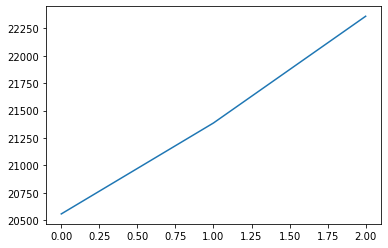

In [57]:
data_sample_metrics(5, '[건강관리]삼성바이오로직스')

* 금융

2008-10-10 00:00:00
2022-05-31 00:00:00
4981
3


C:\Users\gram\AppData\Local\Temp/ipykernel_8008/3864183076.py:43: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df = df.loc[year:]
C:\Users\gram\AppData\Local\Temp/ipykernel_8008/3864183076.py:54: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  x_train, x_test, y_train, y_test = train_test_split(df.drop('close', 1), df['close'], test_size=0.2, random_state=11, shuffle=False)


Epoch 1/50
     31/Unknown - 3s 11ms/step - loss: 0.0644 - mse: 0.1288
Epoch 1: val_loss improved from inf to 0.02307, saving model to tmp\ckeckpointer.ckpt
31/31 [==============================] - 4s 37ms/step - loss: 0.0644 - mse: 0.1288 - val_loss: 0.0231 - val_mse: 0.0461
Epoch 2/50
26/31 [========================>.....] - ETA: 0s - loss: 0.0040 - mse: 0.0080
Epoch 2: val_loss improved from 0.02307 to 0.00782, saving model to tmp\ckeckpointer.ckpt
31/31 [==============================] - 1s 16ms/step - loss: 0.0039 - mse: 0.0077 - val_loss: 0.0078 - val_mse: 0.0156
Epoch 3/50
31/31 [==============================] - ETA: 0s - loss: 0.0023 - mse: 0.0046
Epoch 3: val_loss improved from 0.00782 to 0.00239, saving model to tmp\ckeckpointer.ckpt
31/31 [==============================] - 1s 16ms/step - loss: 0.0023 - mse: 0.0046 - val_loss: 0.0024 - val_mse: 0.0048
Epoch 4/50
30/31 [============================>.] - ETA: 0s - loss: 0.0018 - mse: 0.0036
Epoch 4: val_loss did not improve fr

C:\Users\gram\AppData\Local\Temp/ipykernel_8008/3864183076.py:43: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df = df.loc[year:]
C:\Users\gram\AppData\Local\Temp/ipykernel_8008/3864183076.py:54: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  x_train, x_test, y_train, y_test = train_test_split(df.drop('close', 1), df['close'], test_size=0.2, random_state=11, shuffle=False)


Epoch 1/50
     61/Unknown - 4s 13ms/step - loss: 0.0472 - mse: 0.0943
Epoch 1: val_loss improved from inf to 0.00447, saving model to tmp\ckeckpointer.ckpt
61/61 [==============================] - 5s 29ms/step - loss: 0.0472 - mse: 0.0943 - val_loss: 0.0045 - val_mse: 0.0089
Epoch 2/50
58/61 [===========================>..] - ETA: 0s - loss: 0.0020 - mse: 0.0040
Epoch 2: val_loss improved from 0.00447 to 0.00076, saving model to tmp\ckeckpointer.ckpt
61/61 [==============================] - 1s 18ms/step - loss: 0.0019 - mse: 0.0039 - val_loss: 7.6207e-04 - val_mse: 0.0015
Epoch 3/50
59/61 [============================>.] - ETA: 0s - loss: 8.5793e-04 - mse: 0.0017
Epoch 3: val_loss improved from 0.00076 to 0.00040, saving model to tmp\ckeckpointer.ckpt
61/61 [==============================] - 1s 21ms/step - loss: 8.4749e-04 - mse: 0.0017 - val_loss: 3.9891e-04 - val_mse: 7.9782e-04
Epoch 4/50
59/61 [============================>.] - ETA: 0s - loss: 7.2997e-04 - mse: 0.0015
Epoch 4: val

C:\Users\gram\AppData\Local\Temp/ipykernel_8008/3864183076.py:43: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df = df.loc[year:]
C:\Users\gram\AppData\Local\Temp/ipykernel_8008/3864183076.py:54: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  x_train, x_test, y_train, y_test = train_test_split(df.drop('close', 1), df['close'], test_size=0.2, random_state=11, shuffle=False)


Epoch 1/50
     81/Unknown - 7s 17ms/step - loss: 0.0385 - mse: 0.0769
Epoch 1: val_loss improved from inf to 0.00416, saving model to tmp\ckeckpointer.ckpt
84/84 [==============================] - 9s 36ms/step - loss: 0.0373 - mse: 0.0745 - val_loss: 0.0042 - val_mse: 0.0083
Epoch 2/50
83/84 [============================>.] - ETA: 0s - loss: 0.0013 - mse: 0.0027
Epoch 2: val_loss improved from 0.00416 to 0.00159, saving model to tmp\ckeckpointer.ckpt
84/84 [==============================] - 2s 21ms/step - loss: 0.0013 - mse: 0.0026 - val_loss: 0.0016 - val_mse: 0.0032
Epoch 3/50
84/84 [==============================] - ETA: 0s - loss: 5.9814e-04 - mse: 0.0012
Epoch 3: val_loss improved from 0.00159 to 0.00145, saving model to tmp\ckeckpointer.ckpt
84/84 [==============================] - 2s 21ms/step - loss: 5.9814e-04 - mse: 0.0012 - val_loss: 0.0014 - val_mse: 0.0029
Epoch 4/50
84/84 [==============================] - ETA: 0s - loss: 5.7259e-04 - mse: 0.0011
Epoch 4: val_loss improv

Epoch 28/50
82/84 [============================>.] - ETA: 0s - loss: 3.1348e-04 - mse: 6.2697e-04
Epoch 28: val_loss improved from 0.00073 to 0.00072, saving model to tmp\ckeckpointer.ckpt
84/84 [==============================] - 1s 13ms/step - loss: 3.1509e-04 - mse: 6.3018e-04 - val_loss: 7.2371e-04 - val_mse: 0.0014
Epoch 29/50
81/84 [===========================>..] - ETA: 0s - loss: 2.7815e-04 - mse: 5.5631e-04
Epoch 29: val_loss did not improve from 0.00072
84/84 [==============================] - 1s 14ms/step - loss: 2.7836e-04 - mse: 5.5672e-04 - val_loss: 7.3925e-04 - val_mse: 0.0015
Epoch 30/50
84/84 [==============================] - ETA: 0s - loss: 2.6256e-04 - mse: 5.2513e-04
Epoch 30: val_loss did not improve from 0.00072
84/84 [==============================] - 1s 14ms/step - loss: 2.6256e-04 - mse: 5.2513e-04 - val_loss: 8.8415e-04 - val_mse: 0.0018
Epoch 31/50
80/84 [===========================>..] - ETA: 0s - loss: 2.7796e-04 - mse: 5.5592e-04
Epoch 31: val_loss improv

C:\Users\gram\AppData\Local\Temp/ipykernel_8008/3864183076.py:54: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  x_train, x_test, y_train, y_test = train_test_split(df.drop('close', 1), df['close'], test_size=0.2, random_state=11, shuffle=False)


Epoch 1/50
     84/Unknown - 6s 15ms/step - loss: 0.0304 - mse: 0.0608
Epoch 1: val_loss improved from inf to 0.00450, saving model to tmp\ckeckpointer.ckpt
84/84 [==============================] - 7s 33ms/step - loss: 0.0304 - mse: 0.0608 - val_loss: 0.0045 - val_mse: 0.0090
Epoch 2/50
83/84 [============================>.] - ETA: 0s - loss: 0.0016 - mse: 0.0032
Epoch 2: val_loss improved from 0.00450 to 0.00207, saving model to tmp\ckeckpointer.ckpt
84/84 [==============================] - 2s 20ms/step - loss: 0.0016 - mse: 0.0032 - val_loss: 0.0021 - val_mse: 0.0041
Epoch 3/50
83/84 [============================>.] - ETA: 0s - loss: 8.1025e-04 - mse: 0.0016
Epoch 3: val_loss improved from 0.00207 to 0.00168, saving model to tmp\ckeckpointer.ckpt
84/84 [==============================] - 2s 19ms/step - loss: 8.0730e-04 - mse: 0.0016 - val_loss: 0.0017 - val_mse: 0.0034
Epoch 4/50
81/84 [===========================>..] - ETA: 0s - loss: 6.9231e-04 - mse: 0.0014
Epoch 4: val_loss improv

Epoch 28/50
80/84 [===========================>..] - ETA: 0s - loss: 2.6472e-04 - mse: 5.2943e-04
Epoch 28: val_loss improved from 0.00072 to 0.00070, saving model to tmp\ckeckpointer.ckpt
84/84 [==============================] - 1s 14ms/step - loss: 2.6501e-04 - mse: 5.3003e-04 - val_loss: 7.0151e-04 - val_mse: 0.0014
Epoch 29/50
81/84 [===========================>..] - ETA: 0s - loss: 2.8149e-04 - mse: 5.6298e-04
Epoch 29: val_loss did not improve from 0.00070
84/84 [==============================] - 1s 13ms/step - loss: 2.8316e-04 - mse: 5.6631e-04 - val_loss: 8.2952e-04 - val_mse: 0.0017
Epoch 30/50
81/84 [===========================>..] - ETA: 0s - loss: 2.7212e-04 - mse: 5.4425e-04
Epoch 30: val_loss improved from 0.00070 to 0.00069, saving model to tmp\ckeckpointer.ckpt
84/84 [==============================] - 1s 14ms/step - loss: 2.6942e-04 - mse: 5.3884e-04 - val_loss: 6.8614e-04 - val_mse: 0.0014
Epoch 31/50
82/84 [============================>.] - ETA: 0s - loss: 2.5583e-04 

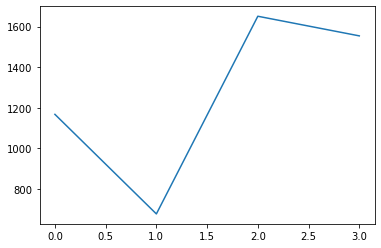

In [58]:
data_sample_metrics(5, '[금융]KB금융')

* IT

1985-01-04 00:00:00
2022-05-31 00:00:00
13661
8


C:\Users\gram\AppData\Local\Temp/ipykernel_8008/3864183076.py:43: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df = df.loc[year:]
C:\Users\gram\AppData\Local\Temp/ipykernel_8008/3864183076.py:54: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  x_train, x_test, y_train, y_test = train_test_split(df.drop('close', 1), df['close'], test_size=0.2, random_state=11, shuffle=False)


Epoch 1/50
     30/Unknown - 6s 24ms/step - loss: 0.0813 - mse: 0.1626
Epoch 1: val_loss improved from inf to 0.00447, saving model to tmp\ckeckpointer.ckpt
31/31 [==============================] - 7s 57ms/step - loss: 0.0812 - mse: 0.1623 - val_loss: 0.0045 - val_mse: 0.0089
Epoch 2/50
28/31 [==========================>...] - ETA: 0s - loss: 0.0157 - mse: 0.0314
Epoch 2: val_loss did not improve from 0.00447
31/31 [==============================] - 1s 18ms/step - loss: 0.0151 - mse: 0.0302 - val_loss: 0.0070 - val_mse: 0.0140
Epoch 3/50
31/31 [==============================] - ETA: 0s - loss: 0.0035 - mse: 0.0069
Epoch 3: val_loss improved from 0.00447 to 0.00191, saving model to tmp\ckeckpointer.ckpt
31/31 [==============================] - 1s 16ms/step - loss: 0.0035 - mse: 0.0069 - val_loss: 0.0019 - val_mse: 0.0038
Epoch 4/50
27/31 [=========================>....] - ETA: 0s - loss: 0.0014 - mse: 0.0029
Epoch 4: val_loss improved from 0.00191 to 0.00063, saving model to tmp\ckeckpo

C:\Users\gram\AppData\Local\Temp/ipykernel_8008/3864183076.py:43: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df = df.loc[year:]
C:\Users\gram\AppData\Local\Temp/ipykernel_8008/3864183076.py:54: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  x_train, x_test, y_train, y_test = train_test_split(df.drop('close', 1), df['close'], test_size=0.2, random_state=11, shuffle=False)


Epoch 1/50
     59/Unknown - 4s 13ms/step - loss: 0.0361 - mse: 0.0723
Epoch 1: val_loss improved from inf to 0.00294, saving model to tmp\ckeckpointer.ckpt
61/61 [==============================] - 5s 31ms/step - loss: 0.0351 - mse: 0.0702 - val_loss: 0.0029 - val_mse: 0.0059
Epoch 2/50
59/61 [============================>.] - ETA: 0s - loss: 0.0015 - mse: 0.0030
Epoch 2: val_loss improved from 0.00294 to 0.00011, saving model to tmp\ckeckpointer.ckpt
61/61 [==============================] - 1s 17ms/step - loss: 0.0015 - mse: 0.0029 - val_loss: 1.1103e-04 - val_mse: 2.2206e-04
Epoch 3/50
61/61 [==============================] - ETA: 0s - loss: 4.2041e-04 - mse: 8.4083e-04
Epoch 3: val_loss improved from 0.00011 to 0.00008, saving model to tmp\ckeckpointer.ckpt
61/61 [==============================] - 1s 19ms/step - loss: 4.2041e-04 - mse: 8.4083e-04 - val_loss: 8.3272e-05 - val_mse: 1.6654e-04
Epoch 4/50
61/61 [==============================] - ETA: 0s - loss: 3.5745e-04 - mse: 7.1489e

C:\Users\gram\AppData\Local\Temp/ipykernel_8008/3864183076.py:43: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df = df.loc[year:]
C:\Users\gram\AppData\Local\Temp/ipykernel_8008/3864183076.py:54: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  x_train, x_test, y_train, y_test = train_test_split(df.drop('close', 1), df['close'], test_size=0.2, random_state=11, shuffle=False)


Epoch 1/50
     90/Unknown - 5s 13ms/step - loss: 0.0590 - mse: 0.1180
Epoch 1: val_loss improved from inf to 0.00608, saving model to tmp\ckeckpointer.ckpt
92/92 [==============================] - 6s 24ms/step - loss: 0.0578 - mse: 0.1155 - val_loss: 0.0061 - val_mse: 0.0122
Epoch 2/50
92/92 [==============================] - ETA: 0s - loss: 0.0014 - mse: 0.0028
Epoch 2: val_loss improved from 0.00608 to 0.00126, saving model to tmp\ckeckpointer.ckpt
92/92 [==============================] - 2s 17ms/step - loss: 0.0014 - mse: 0.0028 - val_loss: 0.0013 - val_mse: 0.0025
Epoch 3/50
92/92 [==============================] - ETA: 0s - loss: 2.3874e-04 - mse: 4.7747e-04
Epoch 3: val_loss improved from 0.00126 to 0.00065, saving model to tmp\ckeckpointer.ckpt
92/92 [==============================] - 2s 17ms/step - loss: 2.3874e-04 - mse: 4.7747e-04 - val_loss: 6.4864e-04 - val_mse: 0.0013
Epoch 4/50
91/92 [============================>.] - ETA: 0s - loss: 2.1299e-04 - mse: 4.2598e-04
Epoch 4:

C:\Users\gram\AppData\Local\Temp/ipykernel_8008/3864183076.py:43: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df = df.loc[year:]
C:\Users\gram\AppData\Local\Temp/ipykernel_8008/3864183076.py:54: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  x_train, x_test, y_train, y_test = train_test_split(df.drop('close', 1), df['close'], test_size=0.2, random_state=11, shuffle=False)


Epoch 1/50
    121/Unknown - 5s 14ms/step - loss: 0.0395 - mse: 0.0789
Epoch 1: val_loss improved from inf to 0.00026, saving model to tmp\ckeckpointer.ckpt
123/123 [==============================] - 6s 25ms/step - loss: 0.0388 - mse: 0.0777 - val_loss: 2.6216e-04 - val_mse: 5.2432e-04
Epoch 2/50
122/123 [============================>.] - ETA: 0s - loss: 6.2562e-04 - mse: 0.0013
Epoch 2: val_loss improved from 0.00026 to 0.00005, saving model to tmp\ckeckpointer.ckpt
123/123 [==============================] - 2s 18ms/step - loss: 6.2103e-04 - mse: 0.0012 - val_loss: 5.1800e-05 - val_mse: 1.0360e-04
Epoch 3/50
121/123 [============================>.] - ETA: 0s - loss: 1.3909e-04 - mse: 2.7818e-04
Epoch 3: val_loss did not improve from 0.00005
123/123 [==============================] - 2s 17ms/step - loss: 1.3747e-04 - mse: 2.7494e-04 - val_loss: 5.7011e-05 - val_mse: 1.1402e-04
Epoch 4/50
123/123 [==============================] - ETA: 0s - loss: 1.2984e-04 - mse: 2.5969e-04
Epoch 4: va

C:\Users\gram\AppData\Local\Temp/ipykernel_8008/3864183076.py:43: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df = df.loc[year:]
C:\Users\gram\AppData\Local\Temp/ipykernel_8008/3864183076.py:54: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  x_train, x_test, y_train, y_test = train_test_split(df.drop('close', 1), df['close'], test_size=0.2, random_state=11, shuffle=False)


Epoch 1/50
    154/Unknown - 4s 13ms/step - loss: 0.0222 - mse: 0.0444
Epoch 1: val_loss improved from inf to 0.00127, saving model to tmp\ckeckpointer.ckpt
156/156 [==============================] - 6s 21ms/step - loss: 0.0220 - mse: 0.0440 - val_loss: 0.0013 - val_mse: 0.0025
Epoch 2/50
155/156 [============================>.] - ETA: 0s - loss: 8.5439e-04 - mse: 0.0017
Epoch 2: val_loss improved from 0.00127 to 0.00036, saving model to tmp\ckeckpointer.ckpt
156/156 [==============================] - 2s 14ms/step - loss: 8.5179e-04 - mse: 0.0017 - val_loss: 3.5579e-04 - val_mse: 7.1158e-04
Epoch 3/50
154/156 [============================>.] - ETA: 0s - loss: 1.0418e-04 - mse: 2.0835e-04
Epoch 3: val_loss improved from 0.00036 to 0.00027, saving model to tmp\ckeckpointer.ckpt
156/156 [==============================] - 2s 14ms/step - loss: 1.0363e-04 - mse: 2.0727e-04 - val_loss: 2.6772e-04 - val_mse: 5.3544e-04
Epoch 4/50
154/156 [============================>.] - ETA: 0s - loss: 9.182

Epoch 27/50
153/156 [============================>.] - ETA: 0s - loss: 5.4444e-05 - mse: 1.0889e-04
Epoch 27: val_loss did not improve from 0.00004
156/156 [==============================] - 3s 18ms/step - loss: 5.3840e-05 - mse: 1.0768e-04 - val_loss: 4.5199e-05 - val_mse: 9.0399e-05
Epoch 28/50
153/156 [============================>.] - ETA: 0s - loss: 5.5834e-05 - mse: 1.1167e-04
Epoch 28: val_loss did not improve from 0.00004
156/156 [==============================] - 3s 17ms/step - loss: 5.5046e-05 - mse: 1.1009e-04 - val_loss: 5.4068e-05 - val_mse: 1.0814e-04
Epoch 29/50
153/156 [============================>.] - ETA: 0s - loss: 6.0732e-05 - mse: 1.2146e-04
Epoch 29: val_loss did not improve from 0.00004
156/156 [==============================] - 3s 18ms/step - loss: 6.0140e-05 - mse: 1.2028e-04 - val_loss: 6.4008e-05 - val_mse: 1.2802e-04
Epoch 30/50
153/156 [============================>.] - ETA: 0s - loss: 5.0562e-05 - mse: 1.0112e-04
Epoch 30: val_loss did not improve from 0.

C:\Users\gram\AppData\Local\Temp/ipykernel_8008/3864183076.py:43: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df = df.loc[year:]
C:\Users\gram\AppData\Local\Temp/ipykernel_8008/3864183076.py:54: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  x_train, x_test, y_train, y_test = train_test_split(df.drop('close', 1), df['close'], test_size=0.2, random_state=11, shuffle=False)


Epoch 1/50
    191/Unknown - 12s 24ms/step - loss: 0.0255 - mse: 0.0510
Epoch 1: val_loss improved from inf to 0.00001, saving model to tmp\ckeckpointer.ckpt
193/193 [==============================] - 15s 43ms/step - loss: 0.0253 - mse: 0.0507 - val_loss: 1.4043e-05 - val_mse: 2.8086e-05
Epoch 2/50
191/193 [============================>.] - ETA: 0s - loss: 8.5786e-04 - mse: 0.0017
Epoch 2: val_loss improved from 0.00001 to 0.00000, saving model to tmp\ckeckpointer.ckpt
193/193 [==============================] - 7s 32ms/step - loss: 8.5232e-04 - mse: 0.0017 - val_loss: 1.8536e-06 - val_mse: 3.7071e-06
Epoch 3/50
192/193 [============================>.] - ETA: 0s - loss: 1.0807e-04 - mse: 2.1614e-04
Epoch 3: val_loss did not improve from 0.00000
193/193 [==============================] - 8s 41ms/step - loss: 1.0793e-04 - mse: 2.1586e-04 - val_loss: 1.9004e-06 - val_mse: 3.8008e-06
Epoch 4/50
193/193 [==============================] - ETA: 0s - loss: 1.0571e-04 - mse: 2.1142e-04
Epoch 4: 

C:\Users\gram\AppData\Local\Temp/ipykernel_8008/3864183076.py:43: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df = df.loc[year:]
C:\Users\gram\AppData\Local\Temp/ipykernel_8008/3864183076.py:54: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  x_train, x_test, y_train, y_test = train_test_split(df.drop('close', 1), df['close'], test_size=0.2, random_state=11, shuffle=False)


Epoch 1/50
    228/Unknown - 13s 27ms/step - loss: 0.0110 - mse: 0.0221
Epoch 1: val_loss improved from inf to 0.00001, saving model to tmp\ckeckpointer.ckpt
229/229 [==============================] - 16s 37ms/step - loss: 0.0110 - mse: 0.0220 - val_loss: 8.5118e-06 - val_mse: 1.7024e-05
Epoch 2/50
226/229 [============================>.] - ETA: 0s - loss: 7.1857e-05 - mse: 1.4371e-04
Epoch 2: val_loss improved from 0.00001 to 0.00000, saving model to tmp\ckeckpointer.ckpt
229/229 [==============================] - 5s 21ms/step - loss: 7.1050e-05 - mse: 1.4210e-04 - val_loss: 2.1701e-06 - val_mse: 4.3403e-06
Epoch 3/50
227/229 [============================>.] - ETA: 0s - loss: 6.0347e-05 - mse: 1.2069e-04
Epoch 3: val_loss improved from 0.00000 to 0.00000, saving model to tmp\ckeckpointer.ckpt
229/229 [==============================] - 4s 18ms/step - loss: 5.9932e-05 - mse: 1.1986e-04 - val_loss: 2.0314e-06 - val_mse: 4.0628e-06
Epoch 4/50
228/229 [============================>.] - ETA

C:\Users\gram\AppData\Local\Temp/ipykernel_8008/3864183076.py:43: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df = df.loc[year:]
C:\Users\gram\AppData\Local\Temp/ipykernel_8008/3864183076.py:54: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  x_train, x_test, y_train, y_test = train_test_split(df.drop('close', 1), df['close'], test_size=0.2, random_state=11, shuffle=False)


Epoch 1/50
    247/Unknown - 8s 16ms/step - loss: 0.0290 - mse: 0.0580
Epoch 1: val_loss improved from inf to 0.00002, saving model to tmp\ckeckpointer.ckpt
247/247 [==============================] - 9s 22ms/step - loss: 0.0290 - mse: 0.0580 - val_loss: 2.4550e-05 - val_mse: 4.9100e-05
Epoch 2/50
245/247 [============================>.] - ETA: 0s - loss: 0.0017 - mse: 0.0034
Epoch 2: val_loss improved from 0.00002 to 0.00000, saving model to tmp\ckeckpointer.ckpt
247/247 [==============================] - 4s 14ms/step - loss: 0.0017 - mse: 0.0033 - val_loss: 1.5834e-06 - val_mse: 3.1667e-06
Epoch 3/50
245/247 [============================>.] - ETA: 0s - loss: 1.5826e-04 - mse: 3.1651e-04
Epoch 3: val_loss improved from 0.00000 to 0.00000, saving model to tmp\ckeckpointer.ckpt
247/247 [==============================] - 4s 15ms/step - loss: 1.5739e-04 - mse: 3.1478e-04 - val_loss: 1.5525e-06 - val_mse: 3.1050e-06
Epoch 4/50
244/247 [============================>.] - ETA: 0s - loss: 1.016

C:\Users\gram\AppData\Local\Temp/ipykernel_8008/3864183076.py:54: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  x_train, x_test, y_train, y_test = train_test_split(df.drop('close', 1), df['close'], test_size=0.2, random_state=11, shuffle=False)


Epoch 1/50
    247/Unknown - 7s 14ms/step - loss: 0.0086 - mse: 0.0172
Epoch 1: val_loss improved from inf to 0.00001, saving model to tmp\ckeckpointer.ckpt
247/247 [==============================] - 8s 21ms/step - loss: 0.0086 - mse: 0.0172 - val_loss: 5.4123e-06 - val_mse: 1.0825e-05
Epoch 2/50
244/247 [============================>.] - ETA: 0s - loss: 3.8851e-04 - mse: 7.7702e-04
Epoch 2: val_loss improved from 0.00001 to 0.00000, saving model to tmp\ckeckpointer.ckpt
247/247 [==============================] - 5s 20ms/step - loss: 3.8478e-04 - mse: 7.6956e-04 - val_loss: 5.2606e-08 - val_mse: 1.0521e-07
Epoch 3/50
247/247 [==============================] - ETA: 0s - loss: 6.2122e-05 - mse: 1.2424e-04
Epoch 3: val_loss improved from 0.00000 to 0.00000, saving model to tmp\ckeckpointer.ckpt
247/247 [==============================] - 5s 19ms/step - loss: 6.2122e-05 - mse: 1.2424e-04 - val_loss: 3.1433e-08 - val_mse: 6.2865e-08
Epoch 4/50
246/247 [============================>.] - ETA: 

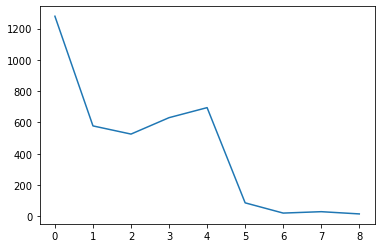

In [59]:
data_sample_metrics(5, '[IT]삼성전자')

* 커뮤니케이션서비스

1998-12-23 00:00:00
2022-05-31 00:00:00
8560
5


C:\Users\gram\AppData\Local\Temp/ipykernel_8008/3864183076.py:43: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df = df.loc[year:]
C:\Users\gram\AppData\Local\Temp/ipykernel_8008/3864183076.py:54: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  x_train, x_test, y_train, y_test = train_test_split(df.drop('close', 1), df['close'], test_size=0.2, random_state=11, shuffle=False)


Epoch 1/50
     29/Unknown - 6s 16ms/step - loss: 0.0992 - mse: 0.1985
Epoch 1: val_loss improved from inf to 0.06431, saving model to tmp\ckeckpointer.ckpt
31/31 [==============================] - 7s 58ms/step - loss: 0.0976 - mse: 0.1953 - val_loss: 0.0643 - val_mse: 0.1286
Epoch 2/50
30/31 [============================>.] - ETA: 0s - loss: 0.0144 - mse: 0.0287
Epoch 2: val_loss improved from 0.06431 to 0.00141, saving model to tmp\ckeckpointer.ckpt
31/31 [==============================] - 1s 28ms/step - loss: 0.0143 - mse: 0.0287 - val_loss: 0.0014 - val_mse: 0.0028
Epoch 3/50
31/31 [==============================] - ETA: 0s - loss: 0.0028 - mse: 0.0056
Epoch 3: val_loss did not improve from 0.00141
31/31 [==============================] - 1s 23ms/step - loss: 0.0028 - mse: 0.0056 - val_loss: 0.0019 - val_mse: 0.0037
Epoch 4/50
31/31 [==============================] - ETA: 0s - loss: 0.0020 - mse: 0.0040
Epoch 4: val_loss did not improve from 0.00141
31/31 [=========================

31/31 [==============================] - 1s 17ms/step - loss: 4.1721e-04 - mse: 8.3441e-04 - val_loss: 4.3897e-04 - val_mse: 8.7793e-04
Epoch 30/50
31/31 [==============================] - ETA: 0s - loss: 4.1229e-04 - mse: 8.2458e-04
Epoch 30: val_loss improved from 0.00044 to 0.00043, saving model to tmp\ckeckpointer.ckpt
31/31 [==============================] - 1s 16ms/step - loss: 4.1229e-04 - mse: 8.2458e-04 - val_loss: 4.2507e-04 - val_mse: 8.5014e-04
Epoch 31/50
29/31 [===========================>..] - ETA: 0s - loss: 4.1347e-04 - mse: 8.2694e-04
Epoch 31: val_loss did not improve from 0.00043
31/31 [==============================] - 1s 16ms/step - loss: 4.1137e-04 - mse: 8.2273e-04 - val_loss: 4.3942e-04 - val_mse: 8.7885e-04
Epoch 32/50
31/31 [==============================] - ETA: 0s - loss: 4.3381e-04 - mse: 8.6761e-04
Epoch 32: val_loss did not improve from 0.00043
31/31 [==============================] - 1s 15ms/step - loss: 4.3381e-04 - mse: 8.6761e-04 - val_loss: 5.2707e-

C:\Users\gram\AppData\Local\Temp/ipykernel_8008/3864183076.py:43: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df = df.loc[year:]
C:\Users\gram\AppData\Local\Temp/ipykernel_8008/3864183076.py:54: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  x_train, x_test, y_train, y_test = train_test_split(df.drop('close', 1), df['close'], test_size=0.2, random_state=11, shuffle=False)


Epoch 1/50
     60/Unknown - 3s 10ms/step - loss: 0.0350 - mse: 0.0699
Epoch 1: val_loss improved from inf to 0.00496, saving model to tmp\ckeckpointer.ckpt
61/61 [==============================] - 4s 21ms/step - loss: 0.0345 - mse: 0.0690 - val_loss: 0.0050 - val_mse: 0.0099
Epoch 2/50
56/61 [==========================>...] - ETA: 0s - loss: 0.0010 - mse: 0.0020
Epoch 2: val_loss improved from 0.00496 to 0.00317, saving model to tmp\ckeckpointer.ckpt
61/61 [==============================] - 1s 13ms/step - loss: 9.8354e-04 - mse: 0.0020 - val_loss: 0.0032 - val_mse: 0.0063
Epoch 3/50
60/61 [============================>.] - ETA: 0s - loss: 7.1335e-04 - mse: 0.0014
Epoch 3: val_loss improved from 0.00317 to 0.00206, saving model to tmp\ckeckpointer.ckpt
61/61 [==============================] - 1s 13ms/step - loss: 7.0905e-04 - mse: 0.0014 - val_loss: 0.0021 - val_mse: 0.0041
Epoch 4/50
60/61 [============================>.] - ETA: 0s - loss: 5.9612e-04 - mse: 0.0012
Epoch 4: val_loss im

C:\Users\gram\AppData\Local\Temp/ipykernel_8008/3864183076.py:43: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df = df.loc[year:]
C:\Users\gram\AppData\Local\Temp/ipykernel_8008/3864183076.py:54: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  x_train, x_test, y_train, y_test = train_test_split(df.drop('close', 1), df['close'], test_size=0.2, random_state=11, shuffle=False)


Epoch 1/50
     92/Unknown - 3s 10ms/step - loss: 0.0076 - mse: 0.0152
Epoch 1: val_loss improved from inf to 0.00175, saving model to tmp\ckeckpointer.ckpt
92/92 [==============================] - 4s 18ms/step - loss: 0.0076 - mse: 0.0152 - val_loss: 0.0018 - val_mse: 0.0035
Epoch 2/50
88/92 [===========================>..] - ETA: 0s - loss: 5.3553e-04 - mse: 0.0011
Epoch 2: val_loss improved from 0.00175 to 0.00107, saving model to tmp\ckeckpointer.ckpt
92/92 [==============================] - 1s 12ms/step - loss: 5.3112e-04 - mse: 0.0011 - val_loss: 0.0011 - val_mse: 0.0021
Epoch 3/50
88/92 [===========================>..] - ETA: 0s - loss: 2.9800e-04 - mse: 5.9599e-04
Epoch 3: val_loss improved from 0.00107 to 0.00102, saving model to tmp\ckeckpointer.ckpt
92/92 [==============================] - 1s 13ms/step - loss: 3.0454e-04 - mse: 6.0908e-04 - val_loss: 0.0010 - val_mse: 0.0020
Epoch 4/50
91/92 [============================>.] - ETA: 0s - loss: 2.7971e-04 - mse: 5.5943e-04
Epoc

92/92 [==============================] - 1s 13ms/step - loss: 1.0938e-04 - mse: 2.1876e-04 - val_loss: 3.9126e-04 - val_mse: 7.8252e-04
Epoch 28/50
92/92 [==============================] - ETA: 0s - loss: 9.5984e-05 - mse: 1.9197e-04
Epoch 28: val_loss improved from 0.00039 to 0.00038, saving model to tmp\ckeckpointer.ckpt
92/92 [==============================] - 1s 13ms/step - loss: 9.5984e-05 - mse: 1.9197e-04 - val_loss: 3.8038e-04 - val_mse: 7.6076e-04
Epoch 29/50
89/92 [============================>.] - ETA: 0s - loss: 9.4878e-05 - mse: 1.8976e-04
Epoch 29: val_loss did not improve from 0.00038
92/92 [==============================] - 1s 13ms/step - loss: 9.5312e-05 - mse: 1.9062e-04 - val_loss: 4.4591e-04 - val_mse: 8.9181e-04
Epoch 30/50
92/92 [==============================] - ETA: 0s - loss: 9.7212e-05 - mse: 1.9442e-04
Epoch 30: val_loss did not improve from 0.00038
92/92 [==============================] - 1s 13ms/step - loss: 9.7212e-05 - mse: 1.9442e-04 - val_loss: 4.2070e-

C:\Users\gram\AppData\Local\Temp/ipykernel_8008/3864183076.py:43: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df = df.loc[year:]
C:\Users\gram\AppData\Local\Temp/ipykernel_8008/3864183076.py:54: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  x_train, x_test, y_train, y_test = train_test_split(df.drop('close', 1), df['close'], test_size=0.2, random_state=11, shuffle=False)


Epoch 1/50
    119/Unknown - 3s 10ms/step - loss: 0.0045 - mse: 0.0090
Epoch 1: val_loss improved from inf to 0.00102, saving model to tmp\ckeckpointer.ckpt
123/123 [==============================] - 4s 17ms/step - loss: 0.0044 - mse: 0.0088 - val_loss: 0.0010 - val_mse: 0.0020
Epoch 2/50
119/123 [============================>.] - ETA: 0s - loss: 4.3089e-04 - mse: 8.6178e-04
Epoch 2: val_loss improved from 0.00102 to 0.00067, saving model to tmp\ckeckpointer.ckpt
123/123 [==============================] - 2s 12ms/step - loss: 4.3855e-04 - mse: 8.7709e-04 - val_loss: 6.6702e-04 - val_mse: 0.0013
Epoch 3/50
121/123 [============================>.] - ETA: 0s - loss: 3.5002e-04 - mse: 7.0003e-04
Epoch 3: val_loss improved from 0.00067 to 0.00063, saving model to tmp\ckeckpointer.ckpt
123/123 [==============================] - 2s 12ms/step - loss: 3.5493e-04 - mse: 7.0985e-04 - val_loss: 6.3253e-04 - val_mse: 0.0013
Epoch 4/50
119/123 [============================>.] - ETA: 0s - loss: 3.288

123/123 [==============================] - 2s 12ms/step - loss: 1.4901e-04 - mse: 2.9801e-04 - val_loss: 2.4286e-04 - val_mse: 4.8572e-04
Epoch 28/50
118/123 [===========================>..] - ETA: 0s - loss: 1.3433e-04 - mse: 2.6866e-04
Epoch 28: val_loss did not improve from 0.00024
123/123 [==============================] - 2s 12ms/step - loss: 1.3853e-04 - mse: 2.7706e-04 - val_loss: 2.5985e-04 - val_mse: 5.1970e-04
Epoch 29/50
120/123 [============================>.] - ETA: 0s - loss: 1.4846e-04 - mse: 2.9691e-04
Epoch 29: val_loss did not improve from 0.00024
123/123 [==============================] - 2s 12ms/step - loss: 1.5192e-04 - mse: 3.0384e-04 - val_loss: 2.9574e-04 - val_mse: 5.9148e-04
Epoch 30/50
118/123 [===========================>..] - ETA: 0s - loss: 1.4843e-04 - mse: 2.9685e-04
Epoch 30: val_loss did not improve from 0.00024
123/123 [==============================] - 2s 13ms/step - loss: 1.5266e-04 - mse: 3.0532e-04 - val_loss: 2.8189e-04 - val_mse: 5.6378e-04
Epoc

C:\Users\gram\AppData\Local\Temp/ipykernel_8008/3864183076.py:43: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df = df.loc[year:]
C:\Users\gram\AppData\Local\Temp/ipykernel_8008/3864183076.py:54: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  x_train, x_test, y_train, y_test = train_test_split(df.drop('close', 1), df['close'], test_size=0.2, random_state=11, shuffle=False)


Epoch 1/50
    142/Unknown - 3s 10ms/step - loss: 1.7748e-04 - mse: 3.5495e-04
Epoch 1: val_loss improved from inf to 0.00283, saving model to tmp\ckeckpointer.ckpt
144/144 [==============================] - 4s 15ms/step - loss: 1.7546e-04 - mse: 3.5091e-04 - val_loss: 0.0028 - val_mse: 0.0057
Epoch 2/50
143/144 [============================>.] - ETA: 0s - loss: 2.7505e-05 - mse: 5.5009e-05
Epoch 2: val_loss did not improve from 0.00283
144/144 [==============================] - 2s 11ms/step - loss: 2.7530e-05 - mse: 5.5059e-05 - val_loss: 0.0029 - val_mse: 0.0058
Epoch 3/50
142/144 [============================>.] - ETA: 0s - loss: 2.6476e-05 - mse: 5.2953e-05
Epoch 3: val_loss improved from 0.00283 to 0.00271, saving model to tmp\ckeckpointer.ckpt
144/144 [==============================] - 2s 12ms/step - loss: 2.6623e-05 - mse: 5.3245e-05 - val_loss: 0.0027 - val_mse: 0.0054
Epoch 4/50
144/144 [==============================] - ETA: 0s - loss: 2.5049e-05 - mse: 5.0099e-05
Epoch 4: va

Epoch 29/50
143/144 [============================>.] - ETA: 0s - loss: 9.7766e-06 - mse: 1.9553e-05
Epoch 29: val_loss improved from 0.00186 to 0.00180, saving model to tmp\ckeckpointer.ckpt
144/144 [==============================] - 2s 12ms/step - loss: 9.7908e-06 - mse: 1.9582e-05 - val_loss: 0.0018 - val_mse: 0.0036
Epoch 30/50
140/144 [============================>.] - ETA: 0s - loss: 9.8834e-06 - mse: 1.9767e-05
Epoch 30: val_loss did not improve from 0.00180
144/144 [==============================] - 2s 12ms/step - loss: 1.0001e-05 - mse: 2.0001e-05 - val_loss: 0.0019 - val_mse: 0.0038
Epoch 31/50
140/144 [============================>.] - ETA: 0s - loss: 9.6865e-06 - mse: 1.9373e-05
Epoch 31: val_loss did not improve from 0.00180
144/144 [==============================] - 2s 13ms/step - loss: 9.8070e-06 - mse: 1.9614e-05 - val_loss: 0.0019 - val_mse: 0.0038
Epoch 32/50
141/144 [============================>.] - ETA: 0s - loss: 9.4085e-06 - mse: 1.8817e-05
Epoch 32: val_loss did 

C:\Users\gram\AppData\Local\Temp/ipykernel_8008/3864183076.py:54: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  x_train, x_test, y_train, y_test = train_test_split(df.drop('close', 1), df['close'], test_size=0.2, random_state=11, shuffle=False)


Epoch 1/50
    144/Unknown - 3s 10ms/step - loss: 1.2916e-04 - mse: 2.5833e-04
Epoch 1: val_loss improved from inf to 0.00055, saving model to tmp\ckeckpointer.ckpt
144/144 [==============================] - 4s 16ms/step - loss: 1.2916e-04 - mse: 2.5833e-04 - val_loss: 5.4992e-04 - val_mse: 0.0011
Epoch 2/50
143/144 [============================>.] - ETA: 0s - loss: 2.3157e-05 - mse: 4.6314e-05
Epoch 2: val_loss improved from 0.00055 to 0.00053, saving model to tmp\ckeckpointer.ckpt
144/144 [==============================] - 2s 11ms/step - loss: 2.3146e-05 - mse: 4.6292e-05 - val_loss: 5.2606e-04 - val_mse: 0.0011
Epoch 3/50
140/144 [============================>.] - ETA: 0s - loss: 2.1286e-05 - mse: 4.2572e-05
Epoch 3: val_loss improved from 0.00053 to 0.00050, saving model to tmp\ckeckpointer.ckpt
144/144 [==============================] - 2s 12ms/step - loss: 2.1280e-05 - mse: 4.2561e-05 - val_loss: 5.0259e-04 - val_mse: 0.0010
Epoch 4/50
140/144 [============================>.] - E

Epoch 27/50
144/144 [==============================] - ETA: 0s - loss: 9.2501e-06 - mse: 1.8500e-05
Epoch 27: val_loss did not improve from 0.00022
144/144 [==============================] - 2s 12ms/step - loss: 9.2501e-06 - mse: 1.8500e-05 - val_loss: 2.2524e-04 - val_mse: 4.5048e-04
Epoch 28/50
140/144 [============================>.] - ETA: 0s - loss: 9.3946e-06 - mse: 1.8789e-05
Epoch 28: val_loss did not improve from 0.00022
144/144 [==============================] - 2s 12ms/step - loss: 9.3920e-06 - mse: 1.8784e-05 - val_loss: 2.5573e-04 - val_mse: 5.1146e-04
Epoch 29/50
143/144 [============================>.] - ETA: 0s - loss: 8.5907e-06 - mse: 1.7181e-05
Epoch 29: val_loss did not improve from 0.00022
144/144 [==============================] - 2s 13ms/step - loss: 8.6325e-06 - mse: 1.7265e-05 - val_loss: 2.5131e-04 - val_mse: 5.0263e-04
Epoch 30/50
141/144 [============================>.] - ETA: 0s - loss: 8.5866e-06 - mse: 1.7173e-05
Epoch 30: val_loss improved from 0.00022 t

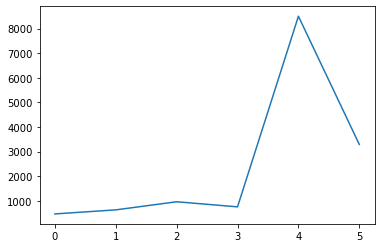

In [60]:
data_sample_metrics(5, '[커뮤니케이션서비스]KT')

* 유틸리티

1989-08-10 00:00:00
2022-05-31 00:00:00
11982
7


C:\Users\gram\AppData\Local\Temp/ipykernel_8008/3864183076.py:43: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df = df.loc[year:]
C:\Users\gram\AppData\Local\Temp/ipykernel_8008/3864183076.py:54: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  x_train, x_test, y_train, y_test = train_test_split(df.drop('close', 1), df['close'], test_size=0.2, random_state=11, shuffle=False)


Epoch 1/50
     28/Unknown - 3s 10ms/step - loss: 0.0477 - mse: 0.0954
Epoch 1: val_loss improved from inf to 0.11445, saving model to tmp\ckeckpointer.ckpt
31/31 [==============================] - 4s 35ms/step - loss: 0.0456 - mse: 0.0911 - val_loss: 0.1145 - val_mse: 0.2289
Epoch 2/50
31/31 [==============================] - ETA: 0s - loss: 0.0050 - mse: 0.0100
Epoch 2: val_loss improved from 0.11445 to 0.02738, saving model to tmp\ckeckpointer.ckpt
31/31 [==============================] - 1s 14ms/step - loss: 0.0050 - mse: 0.0100 - val_loss: 0.0274 - val_mse: 0.0548
Epoch 3/50
31/31 [==============================] - ETA: 0s - loss: 0.0023 - mse: 0.0045
Epoch 3: val_loss improved from 0.02738 to 0.01358, saving model to tmp\ckeckpointer.ckpt
31/31 [==============================] - 1s 16ms/step - loss: 0.0023 - mse: 0.0045 - val_loss: 0.0136 - val_mse: 0.0272
Epoch 4/50
31/31 [==============================] - ETA: 0s - loss: 0.0014 - mse: 0.0028
Epoch 4: val_loss improved from 0.01

Epoch 30/50
31/31 [==============================] - ETA: 0s - loss: 3.0857e-04 - mse: 6.1715e-04
Epoch 30: val_loss did not improve from 0.00043
31/31 [==============================] - 1s 14ms/step - loss: 3.0857e-04 - mse: 6.1715e-04 - val_loss: 8.2888e-04 - val_mse: 0.0017
Epoch 31/50
31/31 [==============================] - ETA: 0s - loss: 3.0671e-04 - mse: 6.1343e-04
Epoch 31: val_loss improved from 0.00043 to 0.00037, saving model to tmp\ckeckpointer.ckpt
31/31 [==============================] - 1s 16ms/step - loss: 3.0671e-04 - mse: 6.1343e-04 - val_loss: 3.7028e-04 - val_mse: 7.4056e-04
Epoch 32/50
30/31 [============================>.] - ETA: 0s - loss: 3.0796e-04 - mse: 6.1592e-04
Epoch 32: val_loss did not improve from 0.00037
31/31 [==============================] - 1s 14ms/step - loss: 3.0805e-04 - mse: 6.1609e-04 - val_loss: 4.1061e-04 - val_mse: 8.2122e-04
Epoch 33/50
31/31 [==============================] - ETA: 0s - loss: 2.9921e-04 - mse: 5.9842e-04
Epoch 33: val_los

C:\Users\gram\AppData\Local\Temp/ipykernel_8008/3864183076.py:43: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df = df.loc[year:]
C:\Users\gram\AppData\Local\Temp/ipykernel_8008/3864183076.py:54: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  x_train, x_test, y_train, y_test = train_test_split(df.drop('close', 1), df['close'], test_size=0.2, random_state=11, shuffle=False)


Epoch 1/50
     60/Unknown - 4s 12ms/step - loss: 0.0062 - mse: 0.0124
Epoch 1: val_loss improved from inf to 0.00144, saving model to tmp\ckeckpointer.ckpt
61/61 [==============================] - 4s 27ms/step - loss: 0.0061 - mse: 0.0123 - val_loss: 0.0014 - val_mse: 0.0029
Epoch 2/50
60/61 [============================>.] - ETA: 0s - loss: 5.9484e-04 - mse: 0.0012
Epoch 2: val_loss improved from 0.00144 to 0.00026, saving model to tmp\ckeckpointer.ckpt
61/61 [==============================] - 1s 14ms/step - loss: 5.9237e-04 - mse: 0.0012 - val_loss: 2.6425e-04 - val_mse: 5.2849e-04
Epoch 3/50
60/61 [============================>.] - ETA: 0s - loss: 3.5575e-04 - mse: 7.1150e-04
Epoch 3: val_loss did not improve from 0.00026
61/61 [==============================] - 1s 12ms/step - loss: 3.5610e-04 - mse: 7.1219e-04 - val_loss: 2.7702e-04 - val_mse: 5.5404e-04
Epoch 4/50
61/61 [==============================] - ETA: 0s - loss: 3.4753e-04 - mse: 6.9506e-04
Epoch 4: val_loss improved from

61/61 [==============================] - 1s 12ms/step - loss: 2.3260e-04 - mse: 4.6520e-04 - val_loss: 1.6588e-04 - val_mse: 3.3176e-04
Epoch 29/50
59/61 [============================>.] - ETA: 0s - loss: 2.4404e-04 - mse: 4.8809e-04
Epoch 29: val_loss improved from 0.00017 to 0.00016, saving model to tmp\ckeckpointer.ckpt
61/61 [==============================] - 1s 14ms/step - loss: 2.4192e-04 - mse: 4.8385e-04 - val_loss: 1.5977e-04 - val_mse: 3.1954e-04
Epoch 30/50
56/61 [==========================>...] - ETA: 0s - loss: 2.3200e-04 - mse: 4.6400e-04
Epoch 30: val_loss improved from 0.00016 to 0.00016, saving model to tmp\ckeckpointer.ckpt
61/61 [==============================] - 1s 13ms/step - loss: 2.2902e-04 - mse: 4.5804e-04 - val_loss: 1.5613e-04 - val_mse: 3.1227e-04
Epoch 31/50
59/61 [============================>.] - ETA: 0s - loss: 2.2123e-04 - mse: 4.4246e-04
Epoch 31: val_loss did not improve from 0.00016
61/61 [==============================] - 1s 12ms/step - loss: 2.2277

C:\Users\gram\AppData\Local\Temp/ipykernel_8008/3864183076.py:43: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df = df.loc[year:]
C:\Users\gram\AppData\Local\Temp/ipykernel_8008/3864183076.py:54: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  x_train, x_test, y_train, y_test = train_test_split(df.drop('close', 1), df['close'], test_size=0.2, random_state=11, shuffle=False)


Epoch 1/50
     90/Unknown - 3s 10ms/step - loss: 0.0235 - mse: 0.0470
Epoch 1: val_loss improved from inf to 0.00098, saving model to tmp\ckeckpointer.ckpt
92/92 [==============================] - 4s 18ms/step - loss: 0.0230 - mse: 0.0461 - val_loss: 9.8100e-04 - val_mse: 0.0020
Epoch 2/50
89/92 [============================>.] - ETA: 0s - loss: 0.0010 - mse: 0.0020
Epoch 2: val_loss improved from 0.00098 to 0.00056, saving model to tmp\ckeckpointer.ckpt
92/92 [==============================] - 1s 12ms/step - loss: 0.0010 - mse: 0.0020 - val_loss: 5.6255e-04 - val_mse: 0.0011
Epoch 3/50
89/92 [============================>.] - ETA: 0s - loss: 3.8486e-04 - mse: 7.6973e-04
Epoch 3: val_loss did not improve from 0.00056
92/92 [==============================] - 1s 12ms/step - loss: 3.8117e-04 - mse: 7.6234e-04 - val_loss: 5.7227e-04 - val_mse: 0.0011
Epoch 4/50
91/92 [============================>.] - ETA: 0s - loss: 3.7532e-04 - mse: 7.5065e-04
Epoch 4: val_loss improved from 0.00056 to 

C:\Users\gram\AppData\Local\Temp/ipykernel_8008/3864183076.py:43: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df = df.loc[year:]
C:\Users\gram\AppData\Local\Temp/ipykernel_8008/3864183076.py:54: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  x_train, x_test, y_train, y_test = train_test_split(df.drop('close', 1), df['close'], test_size=0.2, random_state=11, shuffle=False)


Epoch 1/50
    118/Unknown - 3s 10ms/step - loss: 0.0158 - mse: 0.0316
Epoch 1: val_loss improved from inf to 0.00189, saving model to tmp\ckeckpointer.ckpt
123/123 [==============================] - 4s 16ms/step - loss: 0.0152 - mse: 0.0304 - val_loss: 0.0019 - val_mse: 0.0038
Epoch 2/50
122/123 [============================>.] - ETA: 0s - loss: 0.0010 - mse: 0.0020
Epoch 2: val_loss improved from 0.00189 to 0.00034, saving model to tmp\ckeckpointer.ckpt
123/123 [==============================] - 2s 12ms/step - loss: 0.0010 - mse: 0.0020 - val_loss: 3.4299e-04 - val_mse: 6.8599e-04
Epoch 3/50
120/123 [============================>.] - ETA: 0s - loss: 4.3781e-04 - mse: 8.7561e-04
Epoch 3: val_loss improved from 0.00034 to 0.00026, saving model to tmp\ckeckpointer.ckpt
123/123 [==============================] - 2s 12ms/step - loss: 4.3728e-04 - mse: 8.7457e-04 - val_loss: 2.5678e-04 - val_mse: 5.1355e-04
Epoch 4/50
123/123 [==============================] - ETA: 0s - loss: 4.0300e-04 - 

C:\Users\gram\AppData\Local\Temp/ipykernel_8008/3864183076.py:43: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df = df.loc[year:]
C:\Users\gram\AppData\Local\Temp/ipykernel_8008/3864183076.py:54: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  x_train, x_test, y_train, y_test = train_test_split(df.drop('close', 1), df['close'], test_size=0.2, random_state=11, shuffle=False)


Epoch 1/50
    155/Unknown - 4s 10ms/step - loss: 0.0239 - mse: 0.0477
Epoch 1: val_loss improved from inf to 0.00132, saving model to tmp\ckeckpointer.ckpt
156/156 [==============================] - 4s 15ms/step - loss: 0.0238 - mse: 0.0476 - val_loss: 0.0013 - val_mse: 0.0026
Epoch 2/50
152/156 [============================>.] - ETA: 0s - loss: 4.5559e-04 - mse: 9.1118e-04
Epoch 2: val_loss improved from 0.00132 to 0.00078, saving model to tmp\ckeckpointer.ckpt
156/156 [==============================] - 2s 12ms/step - loss: 4.5312e-04 - mse: 9.0624e-04 - val_loss: 7.7643e-04 - val_mse: 0.0016
Epoch 3/50
156/156 [==============================] - ETA: 0s - loss: 2.9576e-04 - mse: 5.9151e-04
Epoch 3: val_loss improved from 0.00078 to 0.00071, saving model to tmp\ckeckpointer.ckpt
156/156 [==============================] - 2s 12ms/step - loss: 2.9576e-04 - mse: 5.9151e-04 - val_loss: 7.0971e-04 - val_mse: 0.0014
Epoch 4/50
153/156 [============================>.] - ETA: 0s - loss: 2.783

156/156 [==============================] - 2s 11ms/step - loss: 1.0808e-04 - mse: 2.1616e-04 - val_loss: 2.5409e-04 - val_mse: 5.0817e-04
Epoch 27/50
152/156 [============================>.] - ETA: 0s - loss: 1.0549e-04 - mse: 2.1098e-04
Epoch 27: val_loss improved from 0.00025 to 0.00024, saving model to tmp\ckeckpointer.ckpt
156/156 [==============================] - 2s 12ms/step - loss: 1.0463e-04 - mse: 2.0926e-04 - val_loss: 2.4004e-04 - val_mse: 4.8008e-04
Epoch 28/50
156/156 [==============================] - ETA: 0s - loss: 1.0101e-04 - mse: 2.0201e-04
Epoch 28: val_loss improved from 0.00024 to 0.00023, saving model to tmp\ckeckpointer.ckpt
156/156 [==============================] - 2s 14ms/step - loss: 1.0101e-04 - mse: 2.0201e-04 - val_loss: 2.3319e-04 - val_mse: 4.6637e-04
Epoch 29/50
153/156 [============================>.] - ETA: 0s - loss: 1.0267e-04 - mse: 2.0533e-04
Epoch 29: val_loss improved from 0.00023 to 0.00023, saving model to tmp\ckeckpointer.ckpt
156/156 [====

C:\Users\gram\AppData\Local\Temp/ipykernel_8008/3864183076.py:43: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df = df.loc[year:]
C:\Users\gram\AppData\Local\Temp/ipykernel_8008/3864183076.py:54: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  x_train, x_test, y_train, y_test = train_test_split(df.drop('close', 1), df['close'], test_size=0.2, random_state=11, shuffle=False)


Epoch 1/50
    189/Unknown - 6s 15ms/step - loss: 0.0092 - mse: 0.0184
Epoch 1: val_loss improved from inf to 0.00036, saving model to tmp\ckeckpointer.ckpt
193/193 [==============================] - 7s 20ms/step - loss: 0.0091 - mse: 0.0182 - val_loss: 3.5576e-04 - val_mse: 7.1152e-04
Epoch 2/50
190/193 [============================>.] - ETA: 0s - loss: 4.0367e-04 - mse: 8.0735e-04
Epoch 2: val_loss improved from 0.00036 to 0.00028, saving model to tmp\ckeckpointer.ckpt
193/193 [==============================] - 3s 15ms/step - loss: 4.0469e-04 - mse: 8.0939e-04 - val_loss: 2.7748e-04 - val_mse: 5.5496e-04
Epoch 3/50
189/193 [============================>.] - ETA: 0s - loss: 3.6425e-04 - mse: 7.2850e-04
Epoch 3: val_loss did not improve from 0.00028
193/193 [==============================] - 3s 14ms/step - loss: 3.6682e-04 - mse: 7.3364e-04 - val_loss: 2.9083e-04 - val_mse: 5.8166e-04
Epoch 4/50
189/193 [============================>.] - ETA: 0s - loss: 3.4410e-04 - mse: 6.8821e-04
Epo

193/193 [==============================] - 2s 12ms/step - loss: 1.3426e-04 - mse: 2.6853e-04 - val_loss: 7.7953e-05 - val_mse: 1.5591e-04
Epoch 28/50
191/193 [============================>.] - ETA: 0s - loss: 1.3305e-04 - mse: 2.6609e-04
Epoch 28: val_loss improved from 0.00008 to 0.00007, saving model to tmp\ckeckpointer.ckpt
193/193 [==============================] - 2s 12ms/step - loss: 1.3287e-04 - mse: 2.6575e-04 - val_loss: 7.4459e-05 - val_mse: 1.4892e-04
Epoch 29/50
188/193 [============================>.] - ETA: 0s - loss: 1.3101e-04 - mse: 2.6202e-04
Epoch 29: val_loss did not improve from 0.00007
193/193 [==============================] - 2s 11ms/step - loss: 1.3302e-04 - mse: 2.6604e-04 - val_loss: 1.0745e-04 - val_mse: 2.1490e-04
Epoch 30/50
192/193 [============================>.] - ETA: 0s - loss: 1.3988e-04 - mse: 2.7976e-04
Epoch 30: val_loss did not improve from 0.00007
193/193 [==============================] - 2s 11ms/step - loss: 1.3994e-04 - mse: 2.7987e-04 - val_

C:\Users\gram\AppData\Local\Temp/ipykernel_8008/3864183076.py:43: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df = df.loc[year:]
C:\Users\gram\AppData\Local\Temp/ipykernel_8008/3864183076.py:54: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  x_train, x_test, y_train, y_test = train_test_split(df.drop('close', 1), df['close'], test_size=0.2, random_state=11, shuffle=False)


Epoch 1/50
    212/Unknown - 4s 10ms/step - loss: 0.0069 - mse: 0.0138
Epoch 1: val_loss improved from inf to 0.00025, saving model to tmp\ckeckpointer.ckpt
213/213 [==============================] - 5s 14ms/step - loss: 0.0069 - mse: 0.0137 - val_loss: 2.5459e-04 - val_mse: 5.0918e-04
Epoch 2/50
213/213 [==============================] - ETA: 0s - loss: 2.9484e-04 - mse: 5.8969e-04
Epoch 2: val_loss improved from 0.00025 to 0.00019, saving model to tmp\ckeckpointer.ckpt
213/213 [==============================] - 3s 12ms/step - loss: 2.9484e-04 - mse: 5.8969e-04 - val_loss: 1.9005e-04 - val_mse: 3.8011e-04
Epoch 3/50
212/213 [============================>.] - ETA: 0s - loss: 2.7614e-04 - mse: 5.5228e-04
Epoch 3: val_loss improved from 0.00019 to 0.00017, saving model to tmp\ckeckpointer.ckpt
213/213 [==============================] - 3s 12ms/step - loss: 2.7602e-04 - mse: 5.5204e-04 - val_loss: 1.6951e-04 - val_mse: 3.3902e-04
Epoch 4/50
212/213 [============================>.] - ETA: 

Epoch 27/50
212/213 [============================>.] - ETA: 0s - loss: 1.0612e-04 - mse: 2.1224e-04
Epoch 27: val_loss did not improve from 0.00005
213/213 [==============================] - 3s 12ms/step - loss: 1.0620e-04 - mse: 2.1241e-04 - val_loss: 5.4481e-05 - val_mse: 1.0896e-04
Epoch 28/50
210/213 [============================>.] - ETA: 0s - loss: 1.0042e-04 - mse: 2.0084e-04
Epoch 28: val_loss improved from 0.00005 to 0.00005, saving model to tmp\ckeckpointer.ckpt
213/213 [==============================] - 3s 12ms/step - loss: 1.0125e-04 - mse: 2.0251e-04 - val_loss: 5.2520e-05 - val_mse: 1.0504e-04
Epoch 29/50
210/213 [============================>.] - ETA: 0s - loss: 9.9545e-05 - mse: 1.9909e-04
Epoch 29: val_loss improved from 0.00005 to 0.00005, saving model to tmp\ckeckpointer.ckpt
213/213 [==============================] - 3s 13ms/step - loss: 9.9107e-05 - mse: 1.9821e-04 - val_loss: 5.0256e-05 - val_mse: 1.0051e-04
Epoch 30/50
209/213 [============================>.] - E

C:\Users\gram\AppData\Local\Temp/ipykernel_8008/3864183076.py:54: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  x_train, x_test, y_train, y_test = train_test_split(df.drop('close', 1), df['close'], test_size=0.2, random_state=11, shuffle=False)


Epoch 1/50
    211/Unknown - 5s 12ms/step - loss: 0.0110 - mse: 0.0220
Epoch 1: val_loss improved from inf to 0.00047, saving model to tmp\ckeckpointer.ckpt
213/213 [==============================] - 6s 17ms/step - loss: 0.0109 - mse: 0.0218 - val_loss: 4.7412e-04 - val_mse: 9.4823e-04
Epoch 2/50
211/213 [============================>.] - ETA: 0s - loss: 3.6834e-04 - mse: 7.3668e-04
Epoch 2: val_loss improved from 0.00047 to 0.00030, saving model to tmp\ckeckpointer.ckpt
213/213 [==============================] - 3s 14ms/step - loss: 3.6948e-04 - mse: 7.3895e-04 - val_loss: 3.0380e-04 - val_mse: 6.0761e-04
Epoch 3/50
213/213 [==============================] - ETA: 0s - loss: 3.3169e-04 - mse: 6.6337e-04
Epoch 3: val_loss improved from 0.00030 to 0.00027, saving model to tmp\ckeckpointer.ckpt
213/213 [==============================] - 3s 14ms/step - loss: 3.3169e-04 - mse: 6.6337e-04 - val_loss: 2.6963e-04 - val_mse: 5.3925e-04
Epoch 4/50
209/213 [============================>.] - ETA: 

Epoch 27/50
211/213 [============================>.] - ETA: 0s - loss: 1.1473e-04 - mse: 2.2946e-04
Epoch 27: val_loss did not improve from 0.00006
213/213 [==============================] - 3s 12ms/step - loss: 1.1436e-04 - mse: 2.2871e-04 - val_loss: 6.8031e-05 - val_mse: 1.3606e-04
Epoch 28/50
213/213 [==============================] - ETA: 0s - loss: 1.1345e-04 - mse: 2.2691e-04
Epoch 28: val_loss improved from 0.00006 to 0.00005, saving model to tmp\ckeckpointer.ckpt
213/213 [==============================] - 3s 12ms/step - loss: 1.1345e-04 - mse: 2.2691e-04 - val_loss: 5.4669e-05 - val_mse: 1.0934e-04
Epoch 29/50
213/213 [==============================] - ETA: 0s - loss: 1.1167e-04 - mse: 2.2334e-04
Epoch 29: val_loss did not improve from 0.00005
213/213 [==============================] - 3s 12ms/step - loss: 1.1167e-04 - mse: 2.2334e-04 - val_loss: 5.7990e-05 - val_mse: 1.1598e-04
Epoch 30/50
208/213 [============================>.] - ETA: 0s - loss: 1.0996e-04 - mse: 2.1991e-04

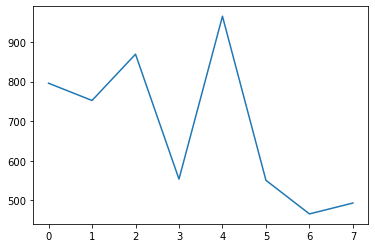

In [61]:
data_sample_metrics(5, '[유틸리티]한국전력')